# Using persistent homology and dynamical distances to analyze protein binding

The data we will be studying in this notebook represents configurations of protein binding.
This example is borrowed from Kovacev-Nikolic et al. [[1]](https://arxiv.org/pdf/1412.1394.pdf).

The paper compares closed and open forms of the maltose-binding protein (MBP), a large biomolecule containing $370$ amino-acid residues. The analysis is not based on geometric distances in $\mathbb R^3$ but on a metric of *dynamical distances* defined by

$$ D_{ij} = 1 - |C_{ij}|, $$

where $C$ is the correlation matrix between residues. Correlation matrices between residues can be found at this [link](https://www.researchgate.net/publication/301543862_corr). We are greatful to the authors for sharing data!

In [1]:
import numpy as np
import sys, os

import gudhi as gd
import gudhi.representations

from sklearn.manifold import Isomap,MDS

sys.path.append('../')
from tools import plot_tools as myplt
from tools import topo_tools as mytop

import matplotlib.pyplot as plt
import seaborn as sns

We first start by reading and storing the imported data into dictionaries.

`corr_mtrx` will store the data of the *cross-correlation matrices* computed from the elastic network model of the 14 different proteins structures.

`dynm_dist` will store the data of the *dynamical distances* defined from the correlation matrices.

`emb_data` will store the data embedded in a lowe-dimensional manifold, using the Isomap method.

In [2]:
SAVE_PLOT = False

In [3]:
FILE_DIR = '../datasets/proteinBinding/'

file_list = []
for entry in os.listdir(FILE_DIR):
    if os.path.isfile(os.path.join(FILE_DIR, entry)):
        if entry.endswith('.txt'):
            file_list.append(entry)

file_list = sorted(file_list)
print(f"Number of files {len(file_list)}\n")
print(file_list)

Number of files 14

['1anf.corr_1.txt', '1ez9.corr_1.txt', '1fqa.corr_2.txt', '1fqb.corr_3.txt', '1fqc.corr_2.txt', '1fqd.corr_3.txt', '1jw4.corr_4.txt', '1jw5.corr_5.txt', '1lls.corr_6.txt', '1mpd.corr_4.txt', '1omp.corr_7.txt', '3hpi.corr_5.txt', '3mbp.corr_6.txt', '4mbp.corr_7.txt']


In [4]:
corr_mtrx = {file[:4] : np.loadtxt(FILE_DIR+file) for file in file_list}

In [5]:
dynm_dist = { corr : (1 - np.abs(corr_mtrx[corr])) for corr in corr_mtrx}

In [6]:
open_ndx = [1,2,3,6,7,8,10]
closed_ndx = [0,5,4,9,11,12,13]
active_res = [12,14,15,62,63,65,66,111,153,154,155,340,344]

To visualize the dynamical distances we used the **Isomap** dimensionality reduction methods, like the authors did in the original article.

In [7]:
embedding = Isomap(n_components=2,
                   metric='precomputed')

In [8]:
emb_data = { sys: embedding.fit_transform(dynm_dist[sys]) for sys in dynm_dist }

In [21]:
emb_data.keys()

dict_keys(['1anf', '1ez9', '1fqa', '1fqb', '1fqc', '1fqd', '1jw4', '1jw5', '1lls', '1mpd', '1omp', '3hpi', '3mbp', '4mbp'])

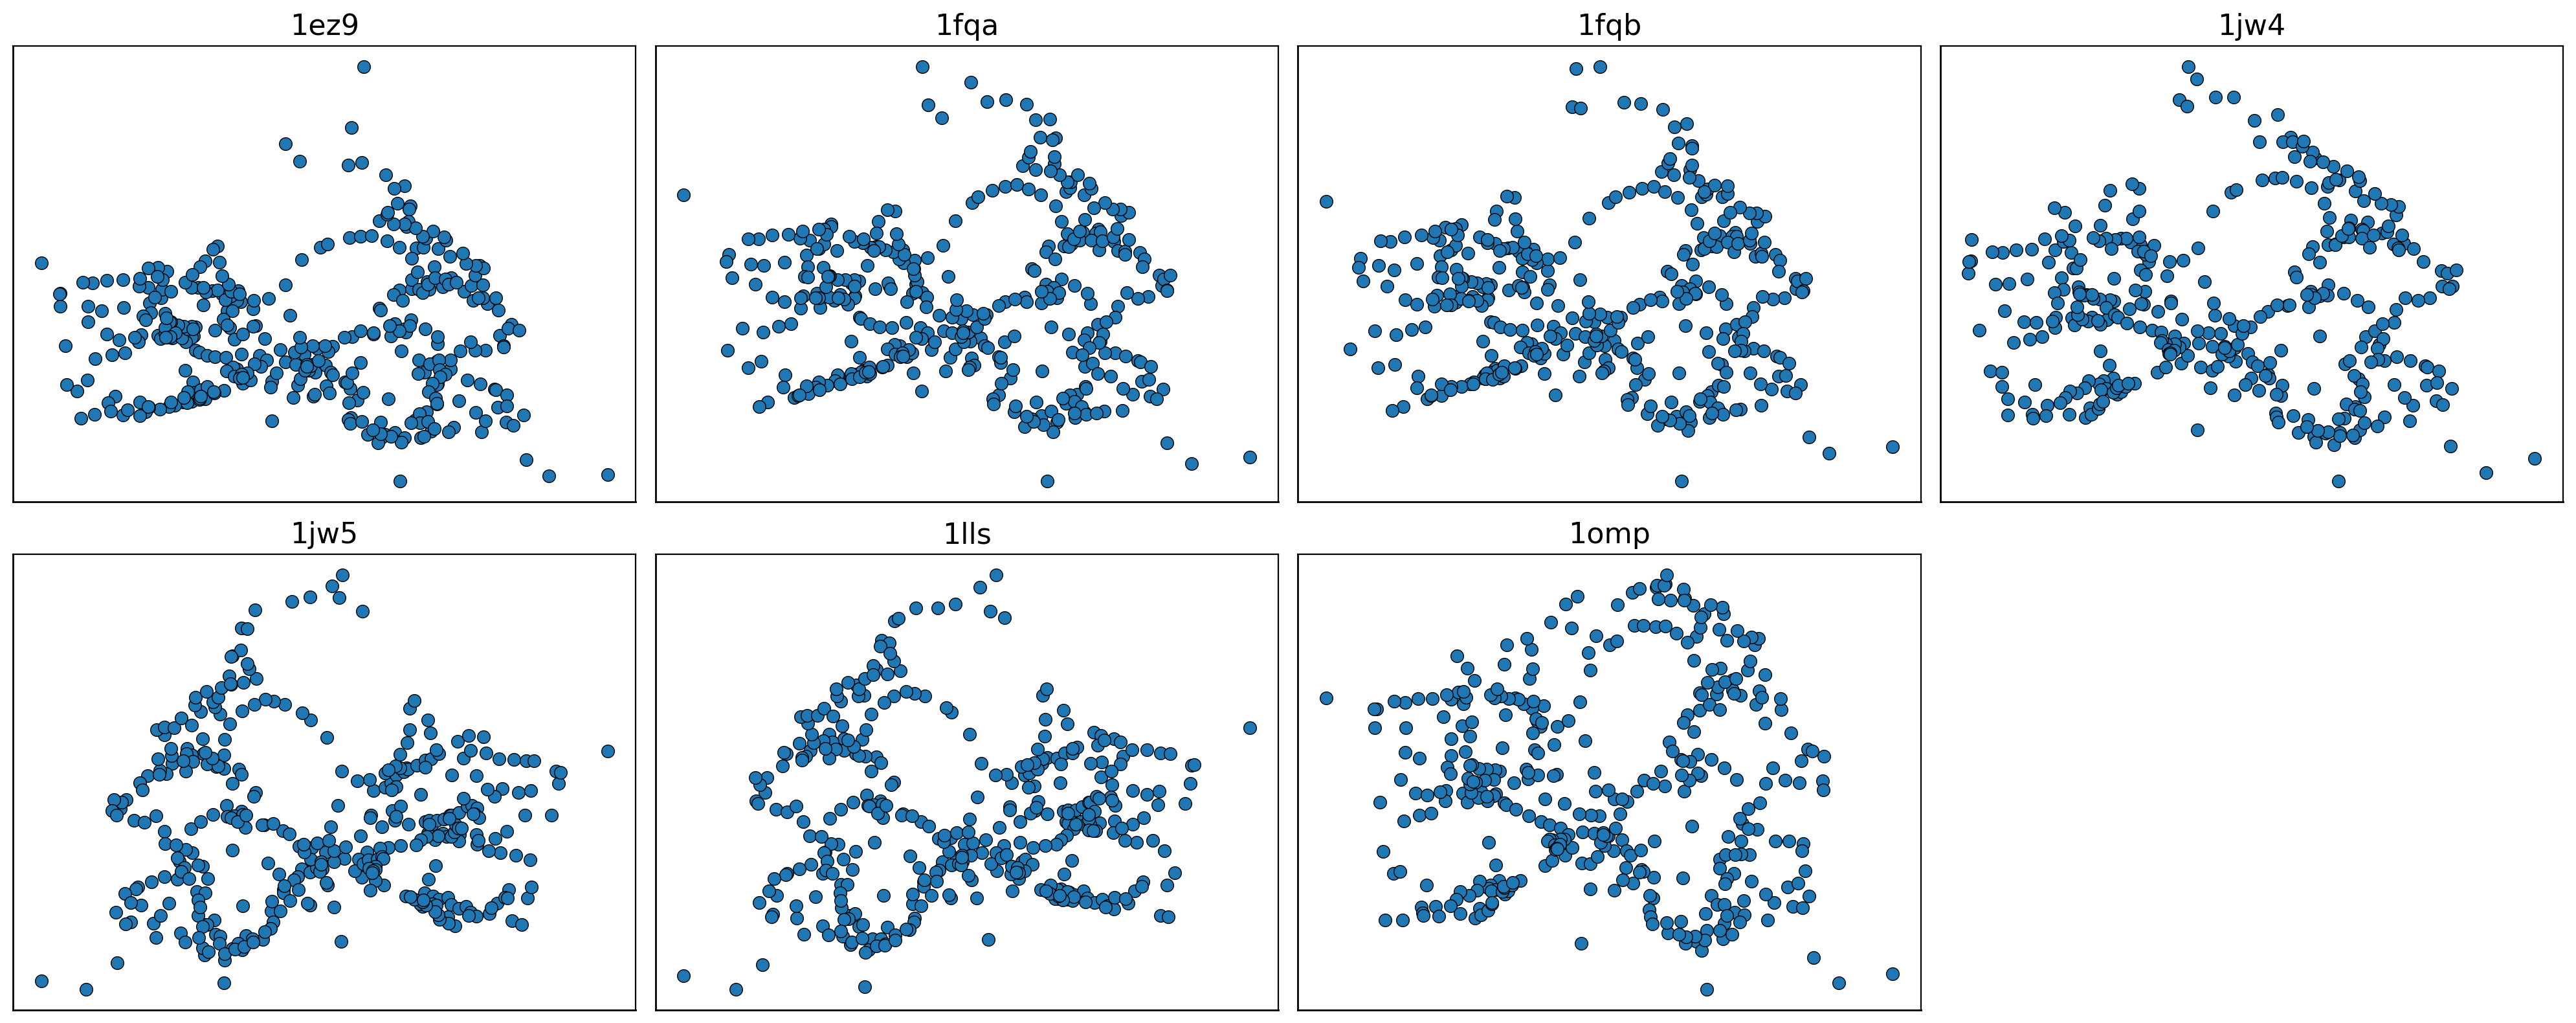

In [9]:
count=0
fig, ax = myplt.get_axes(7, max_col=4, res=200)
for i,j in enumerate(emb_data):
    if i in open_ndx:
        myplt.single_scatter_axe(emb_data[j], ax[count], s=50)
#         myplt.axarrows(fig,ax[count],labels=['x','y'])
        ax[count].set_title(j, size=16)
        
        for side in ['bottom','left']:
            ax[count].spines[side].set_linewidth(1)
        for side in ['right','top']:
            ax[count].spines[side].set_visible(True)
        ax[count].set_yticks([])
        ax[count].set_xticks([])
        ax[count].xaxis.set_ticks_position('none')
        ax[count].yaxis.set_ticks_position('none')
    
        count+=1
        
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("open_dyn_embedding.svg")

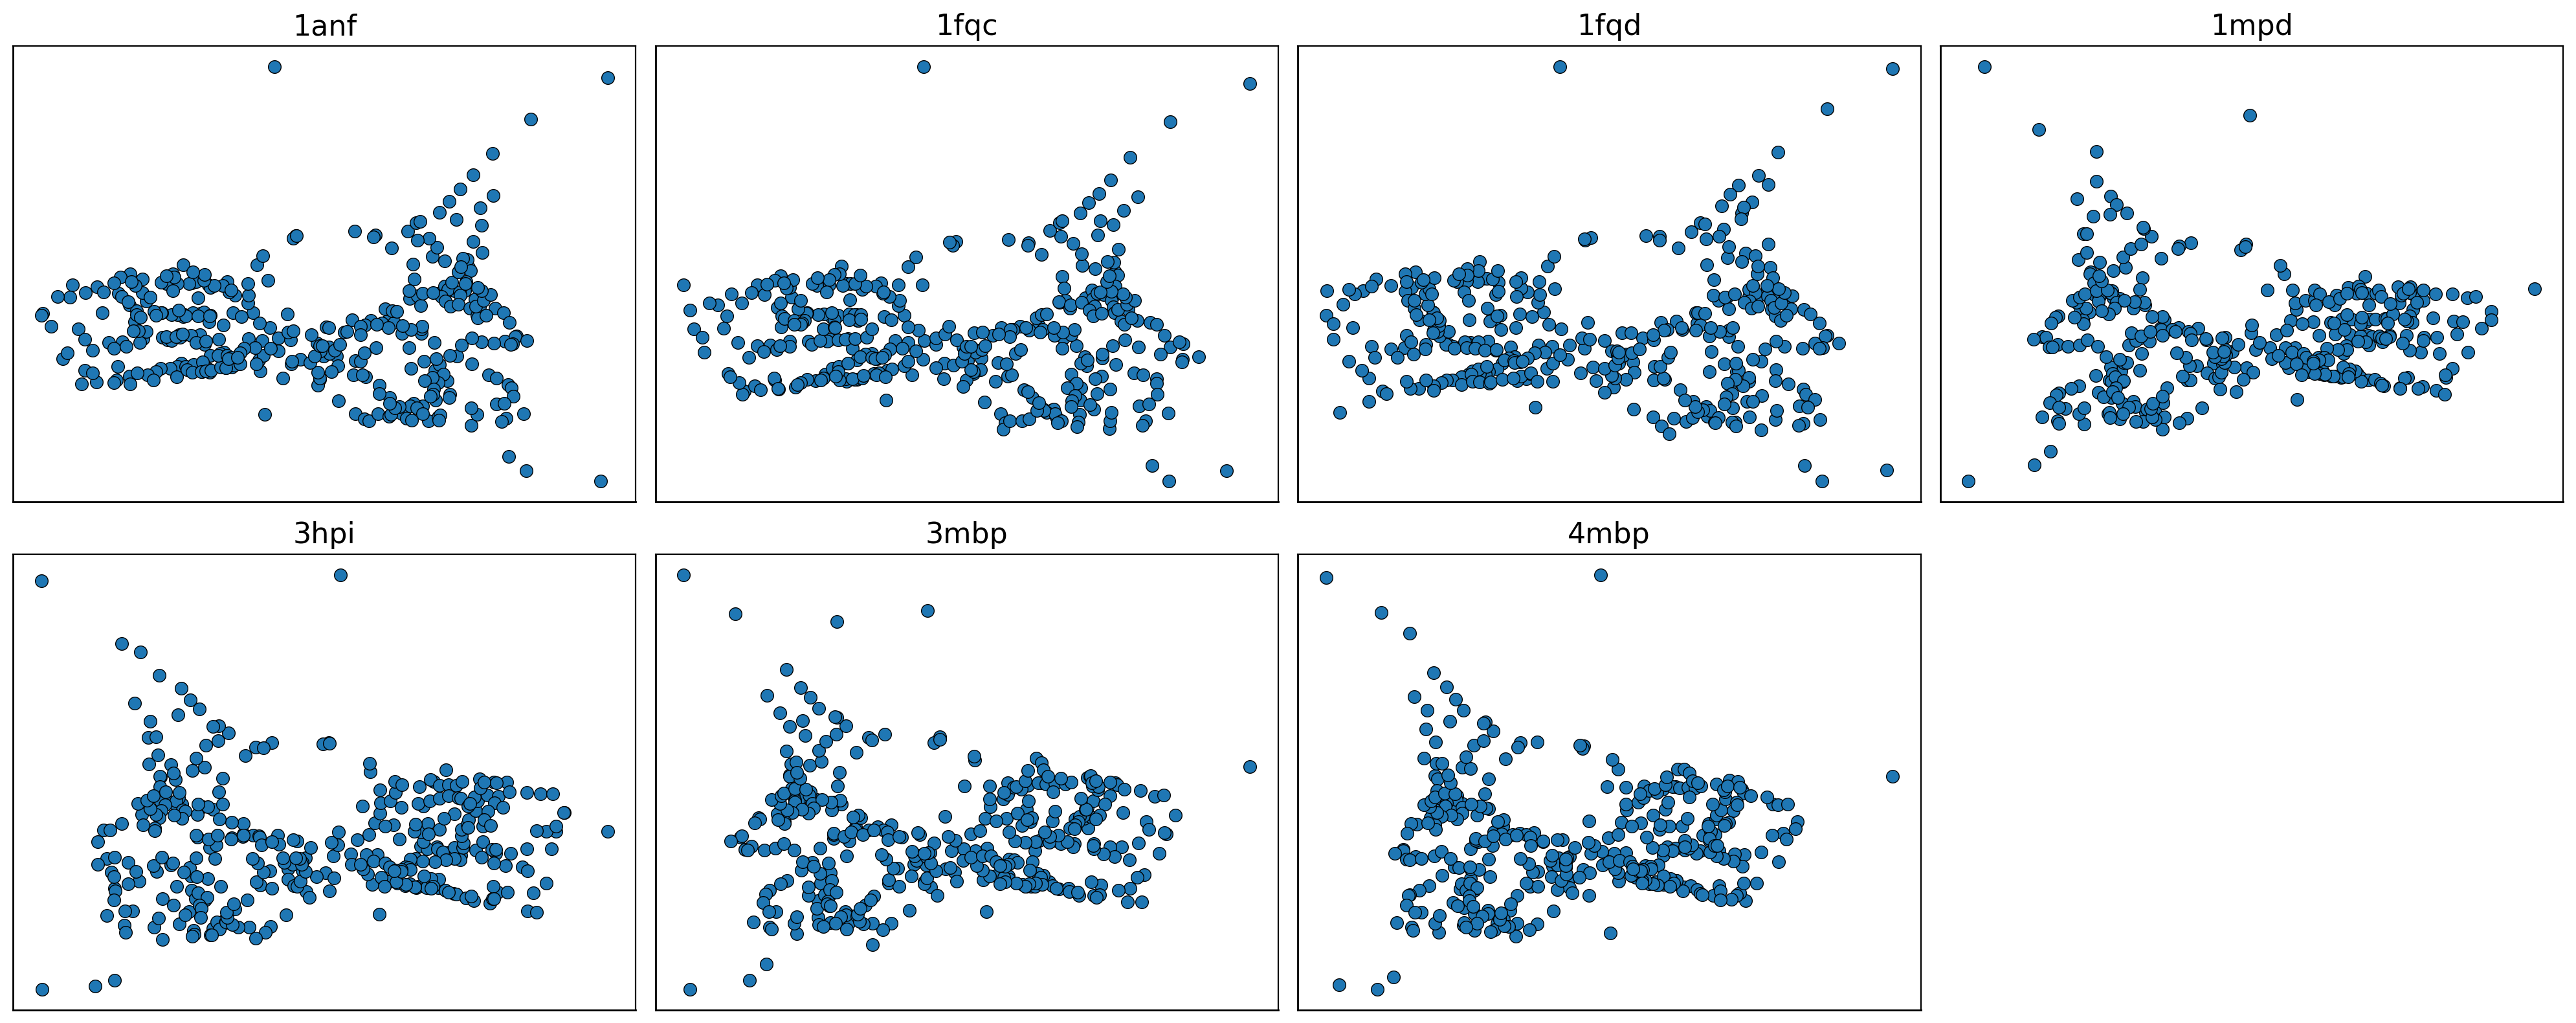

In [10]:
count=0
fig, ax = myplt.get_axes(7, max_col=4, res=200)
for i,j in enumerate(emb_data):
    if i in closed_ndx:
        myplt.single_scatter_axe(emb_data[j], ax[count], s=50)
#         myplt.axarrows(fig,ax[count],labels=['x','y'])
        ax[count].set_title(j, size=16)

        for side in ['bottom','left']:
            ax[count].spines[side].set_linewidth(1)
        for side in ['right','top']:
            ax[count].spines[side].set_visible(True)
        ax[count].set_yticks([])
        ax[count].set_xticks([])
        ax[count].xaxis.set_ticks_position('none')
        ax[count].yaxis.set_ticks_position('none')
    
        count+=1
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("closed_dyn_embedding.svg")

As shown in the paper we can plot the two matricies.

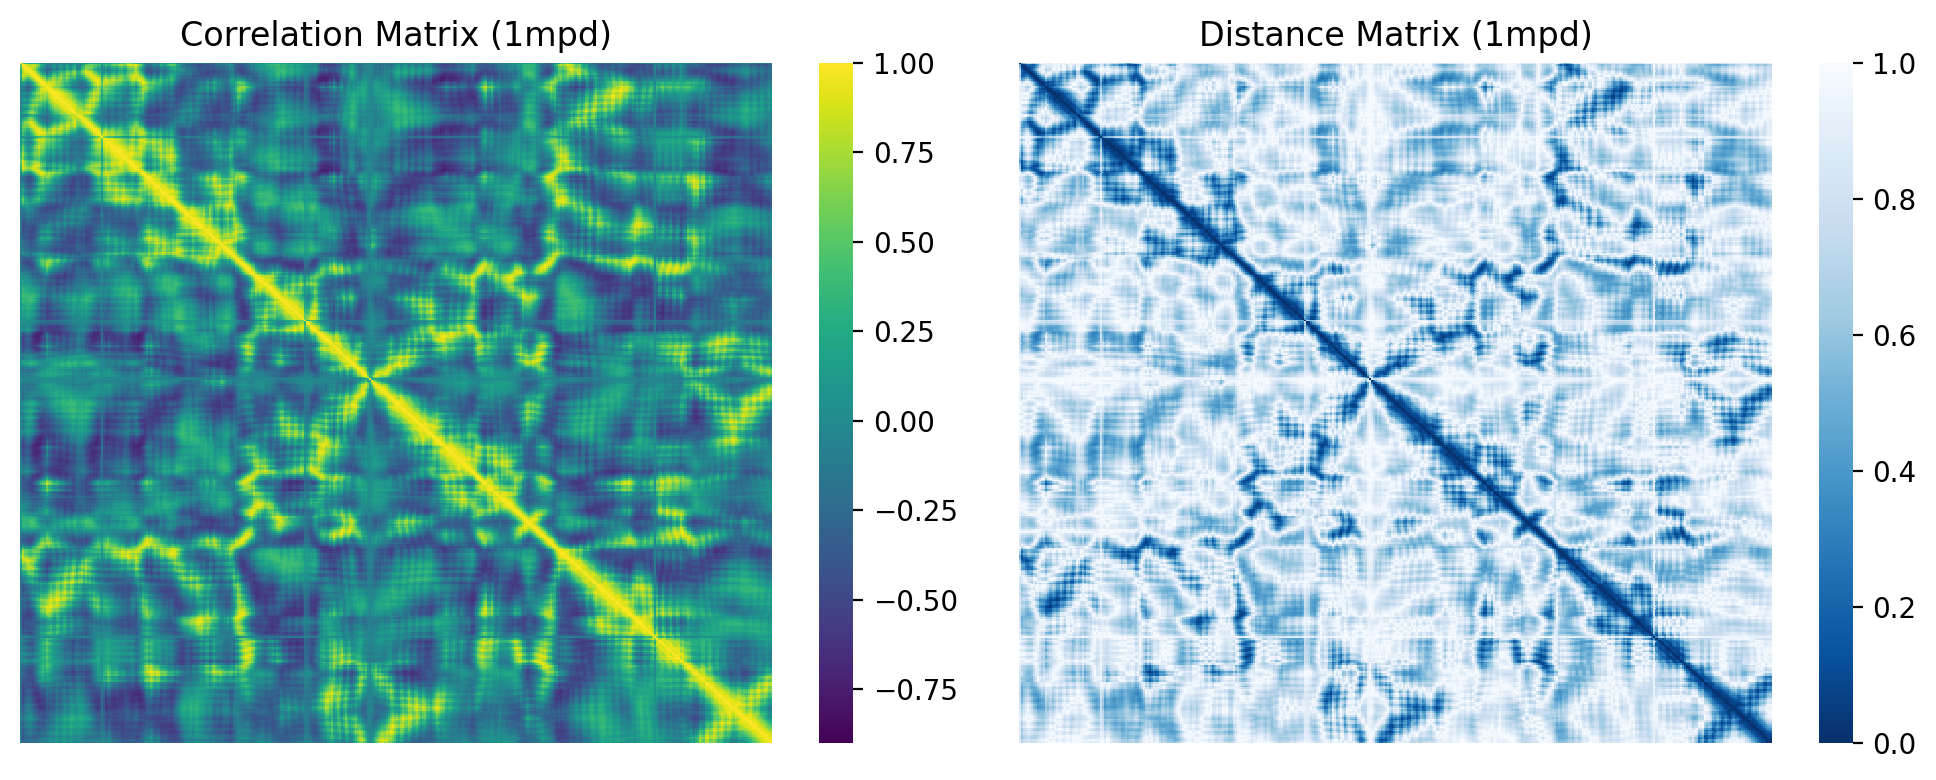

In [11]:
fig, ax = myplt.get_axes(2, max_col=2, res=200)
sns.heatmap(corr_mtrx['1mpd'], vmin=-.9, vmax=1., ax=ax[0], yticklabels=False, xticklabels=False, cmap='viridis')
sns.heatmap(dynm_dist['1mpd'], vmin=0., vmax=1., ax=ax[1], yticklabels=False, xticklabels=False, cmap="Blues_r")
ax[0].set_title("Correlation Matrix (1mpd)")
ax[1].set_title("Distance Matrix (1mpd)")
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("correlation_distance_matrices.svg")

## Topological methods

Using the tools presented in the previous notebook we can compute all the relevant topological quantities; we will use only the data from the dynamical dystances.

In [12]:
# skeleton graph

MEL = 1.0
skeletons = {
    dset: mytop.get_skeleton_from_mtrx(dynm_dist[dset],MEL) for dset in dynm_dist
#     dset: mytop.get_skeleton(emb_data[dset],MEL) for dset in emb_data

}
skeletons

{'1anf': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc510>,
 '1ez9': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc370>,
 '1fqa': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc5e0>,
 '1fqb': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc6b0>,
 '1fqc': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc780>,
 '1fqd': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc850>,
 '1jw4': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc920>,
 '1jw5': <gudhi.rips_complex.RipsComplex at 0x7f25db9fc9f0>,
 '1lls': <gudhi.rips_complex.RipsComplex at 0x7f25db9fcac0>,
 '1mpd': <gudhi.rips_complex.RipsComplex at 0x7f25db9fcb90>,
 '1omp': <gudhi.rips_complex.RipsComplex at 0x7f25db9fcc60>,
 '3hpi': <gudhi.rips_complex.RipsComplex at 0x7f25db9fcd30>,
 '3mbp': <gudhi.rips_complex.RipsComplex at 0x7f25db9fce00>,
 '4mbp': <gudhi.rips_complex.RipsComplex at 0x7f25db9fced0>}

In [13]:
# VR complex

MAX_DIM = 2
VRcomplexes = {
    sk: mytop.get_VRcomplex(skeletons[sk],MAX_DIM) for sk in skeletons
}
VRcomplexes

{'1anf': <gudhi.simplex_tree.SimplexTree at 0x7f25d0673cc0>,
 '1ez9': <gudhi.simplex_tree.SimplexTree at 0x7f25db802d50>,
 '1fqa': <gudhi.simplex_tree.SimplexTree at 0x7f25db802c00>,
 '1fqb': <gudhi.simplex_tree.SimplexTree at 0x7f25db802420>,
 '1fqc': <gudhi.simplex_tree.SimplexTree at 0x7f25db802450>,
 '1fqd': <gudhi.simplex_tree.SimplexTree at 0x7f25db802480>,
 '1jw4': <gudhi.simplex_tree.SimplexTree at 0x7f25db802570>,
 '1jw5': <gudhi.simplex_tree.SimplexTree at 0x7f25d0733fc0>,
 '1lls': <gudhi.simplex_tree.SimplexTree at 0x7f25db802540>,
 '1mpd': <gudhi.simplex_tree.SimplexTree at 0x7f25d0673ed0>,
 '1omp': <gudhi.simplex_tree.SimplexTree at 0x7f25d0673a20>,
 '3hpi': <gudhi.simplex_tree.SimplexTree at 0x7f25d07400f0>,
 '3mbp': <gudhi.simplex_tree.SimplexTree at 0x7f25db7ebfc0>,
 '4mbp': <gudhi.simplex_tree.SimplexTree at 0x7f25db7ebb10>}

In [14]:
# Persistence pairs

barCodes = {
    vr: mytop.get_barCode(VRcomplexes[vr]) for vr in VRcomplexes
}
barCodes.keys()

dict_keys(['1anf', '1ez9', '1fqa', '1fqb', '1fqc', '1fqd', '1jw4', '1jw5', '1lls', '1mpd', '1omp', '3hpi', '3mbp', '4mbp'])

### Visual results

In order to visualize the data, we will focus only on 2 structures, one *open* and one *closed* (as did by the authors in the original work).

In [15]:
def barcode_dimension(barcode, dimension, sort=True):
    brc_tmp = []
    if sort:
        barcode = sorted(barcode)
    for entry in barcode:
        if entry[0] == dimension:
            brc_tmp.append(entry)
    return brc_tmp

In [16]:
VISUAL = ['1mpd', '1omp']

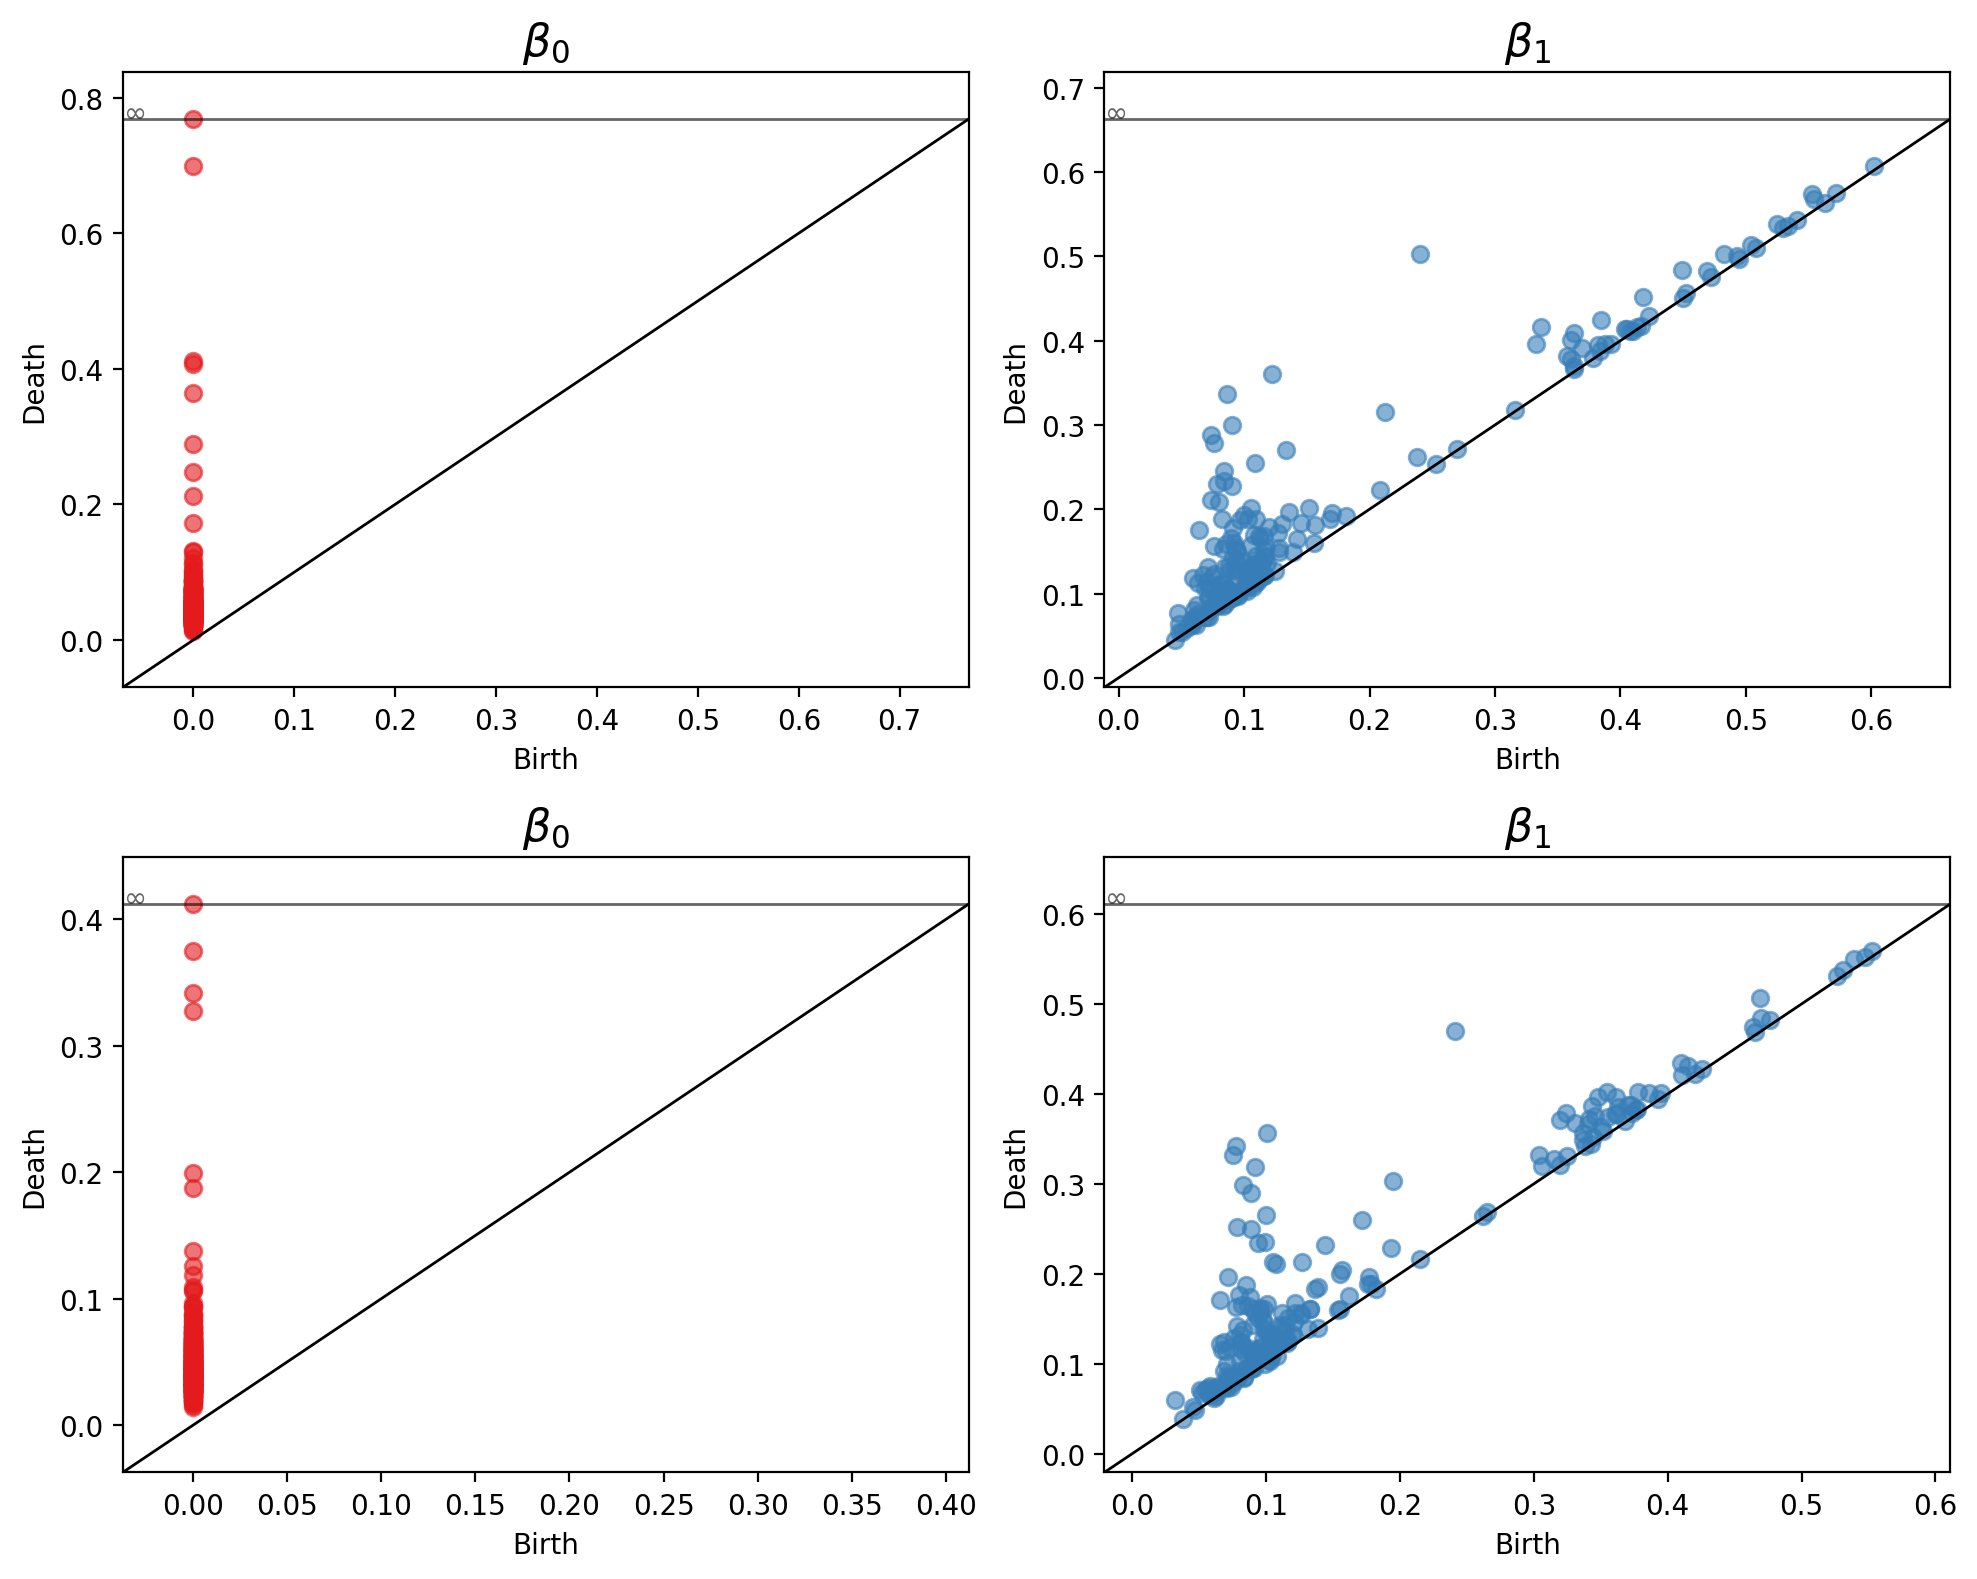

In [17]:
dimensions = np.arange(MAX_DIM)
count=0

fig, ax = myplt.get_axes(len(VISUAL)*len(dimensions), max_col=len(dimensions), res=200)
for sys in VISUAL:
    for dim in dimensions:
        brc_ = barcode_dimension(barCodes[sys], dim, sort=False)
        gd.plot_persistence_diagram(brc_, axes=ax[count])
        ax[count].set_title(r'$\beta_'+str(dim)+'$', size=16)
#         for side in ['right','top']:
#             ax[count].spines[side].set_visible(False)        
        count+=1
# ax[0].set_ylabel(VISUAL[0], size=16)
# ax[0+len(dimensions)].set_ylabel(VISUAL[1], size=16)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("persistence_diagrams_closed_open.svg")

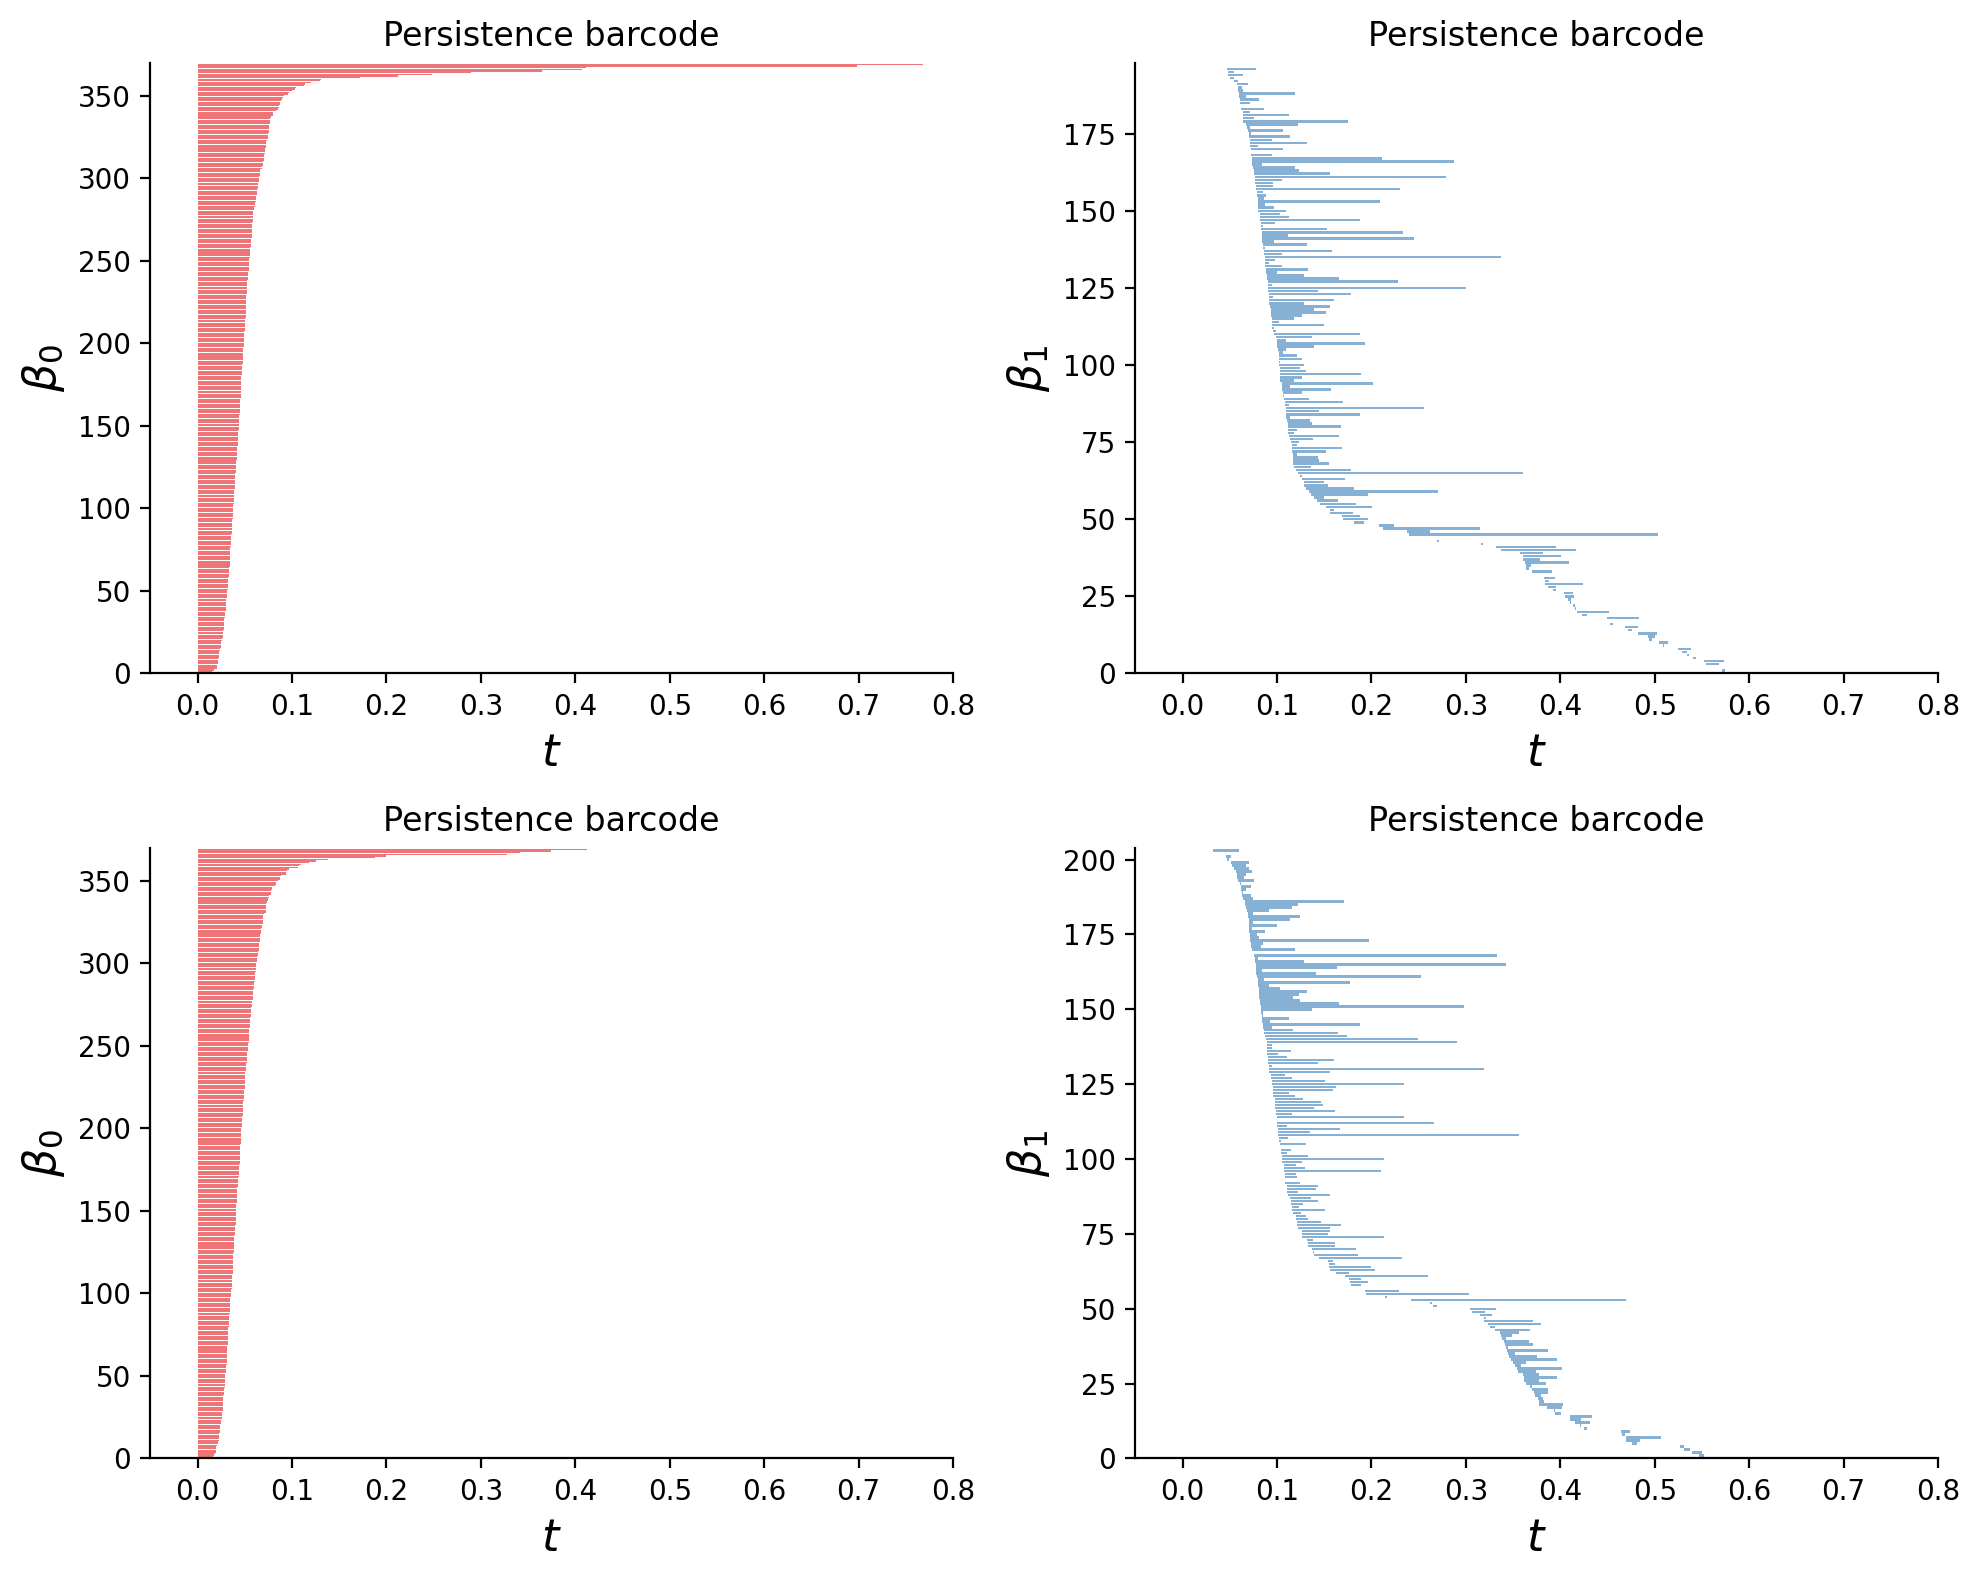

In [18]:
count=0

fig, ax = myplt.get_axes(len(VISUAL)*len(dimensions), max_col=len(dimensions), res=200)
for sys in VISUAL:
    for dim in dimensions:
        brc_ = barcode_dimension(barCodes[sys], dim, sort=False)
        gd.plot_persistence_barcode(persistence=brc_, legend=False, axes=ax[count])
        ax[count].set_ylabel(r'$\beta_'+str(dim)+'$', size=16)
        ax[count].set_xlabel(r'$t$', size=16)
        ax[count].set_xlim((-0.05,0.8))
        for side in ['right','top']:
            ax[count].spines[side].set_visible(False)
        count+=1
# ax[0].set_ylabel(VISUAL[0], size=16)
# ax[0+len(dimensions)].set_ylabel(VISUAL[1], size=16)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("persistence_barcodes_closed_open.svg")

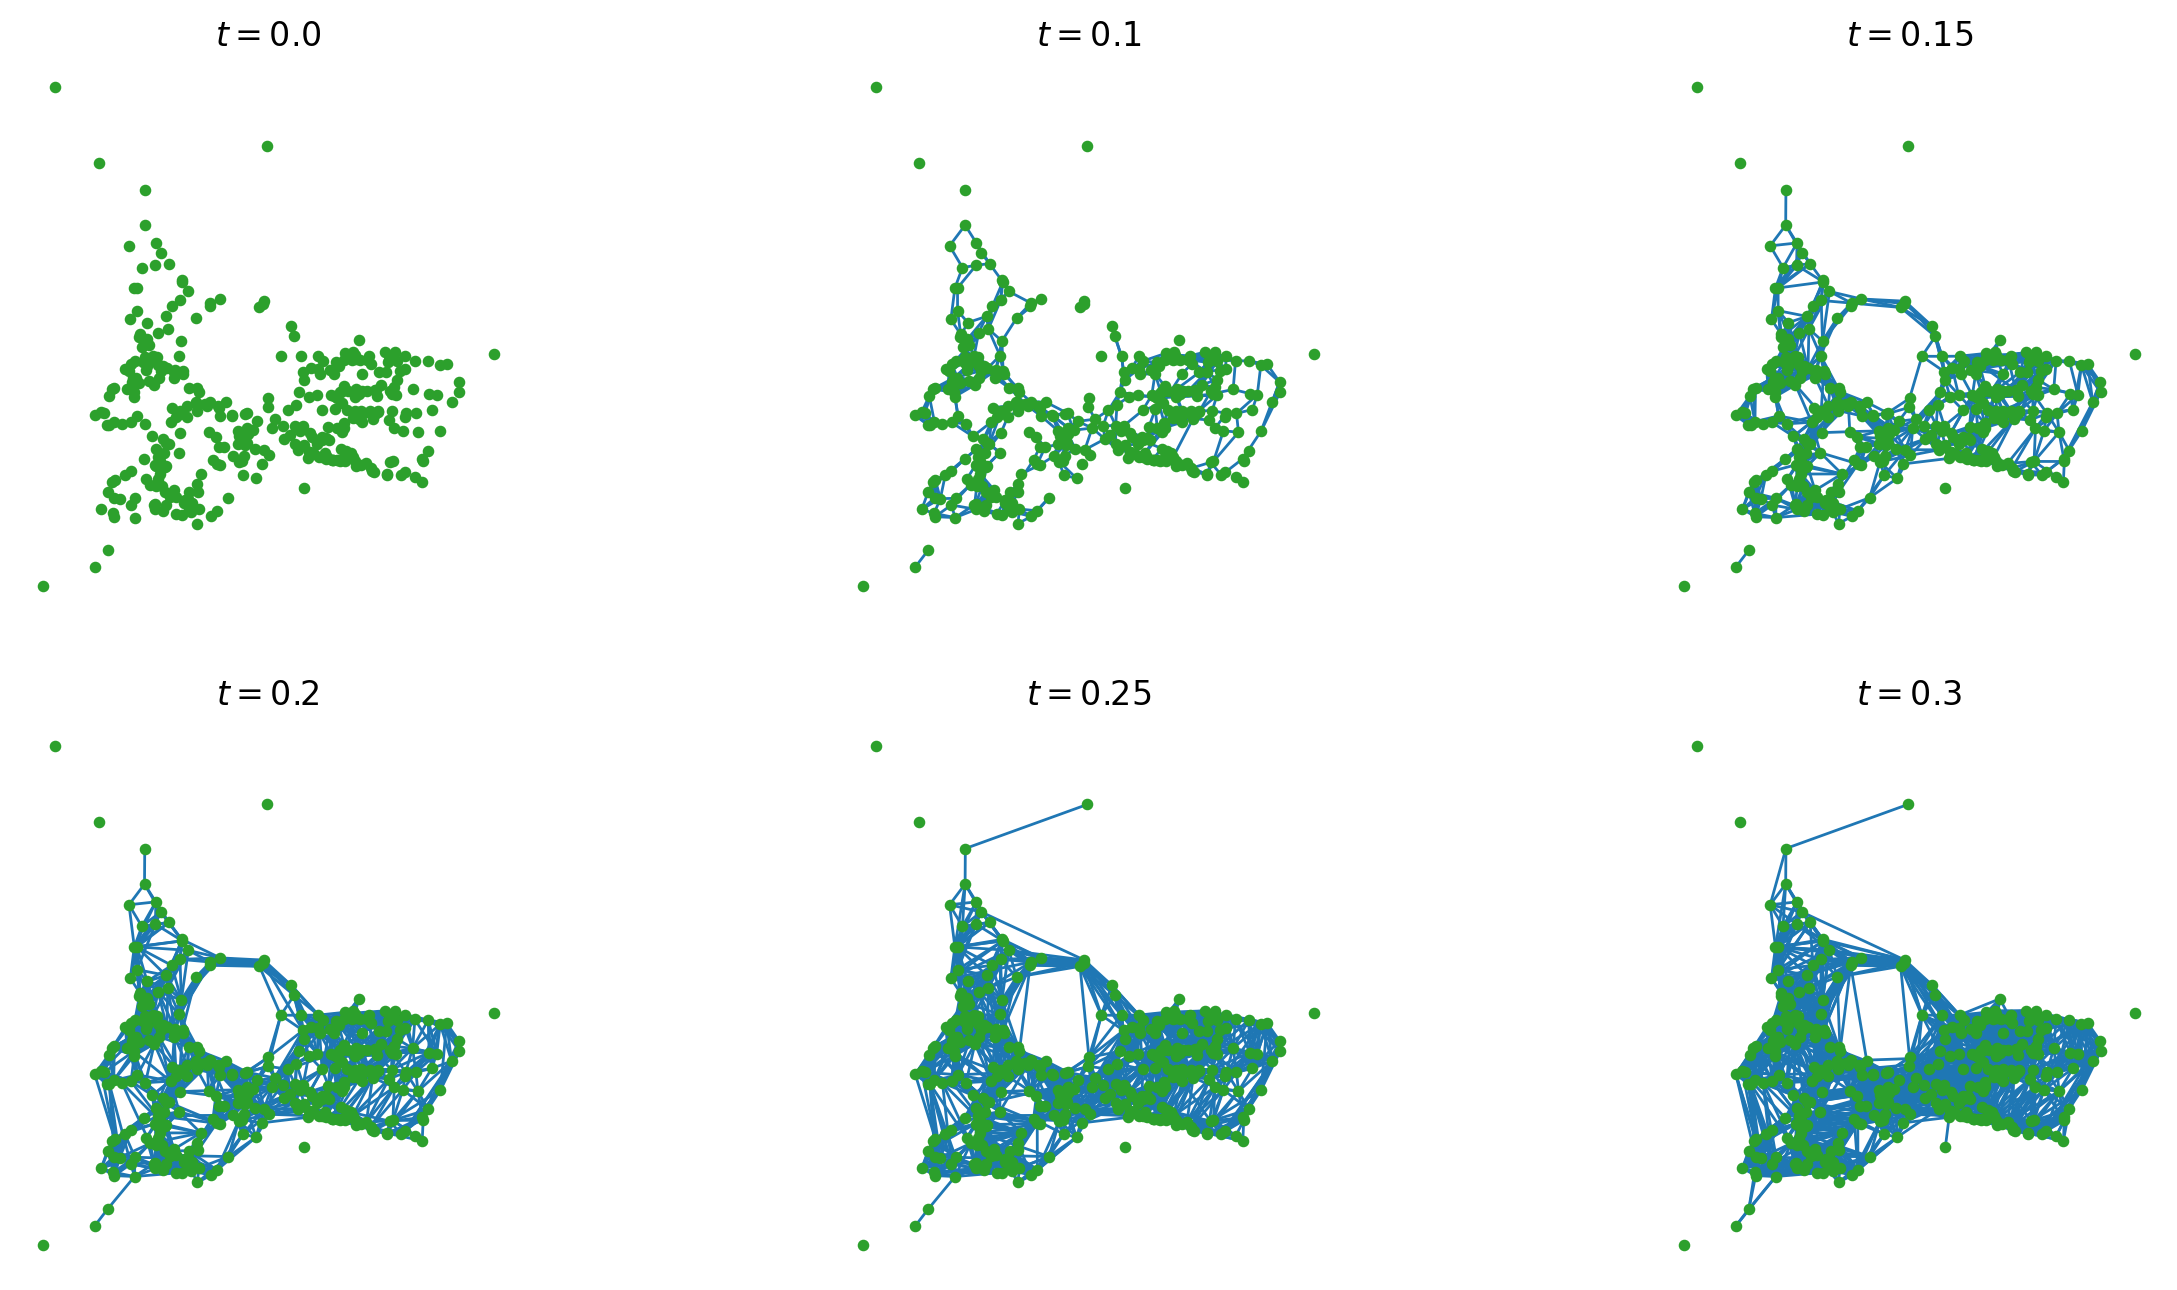

In [19]:
filtration_cycle = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3]
fig, ax = myplt.get_axes(len(filtration_cycle), max_col=3, res=200)
for i,fil in enumerate(filtration_cycle):
    filtration = mytop.get_filtration(emb_data['1mpd'],VRcomplexes['1mpd'],r=fil)
    mytop.plt_filtration(emb_data['1mpd'], filtration, r=fil, dotsize=10, axes=ax[i])
    ax[i].set_title(r'$t='+str(fil)+'$')
    ax[i].set_aspect('equal')
if SAVE_PLOT:
    plt.savefig("filtration_1mpd.svg")

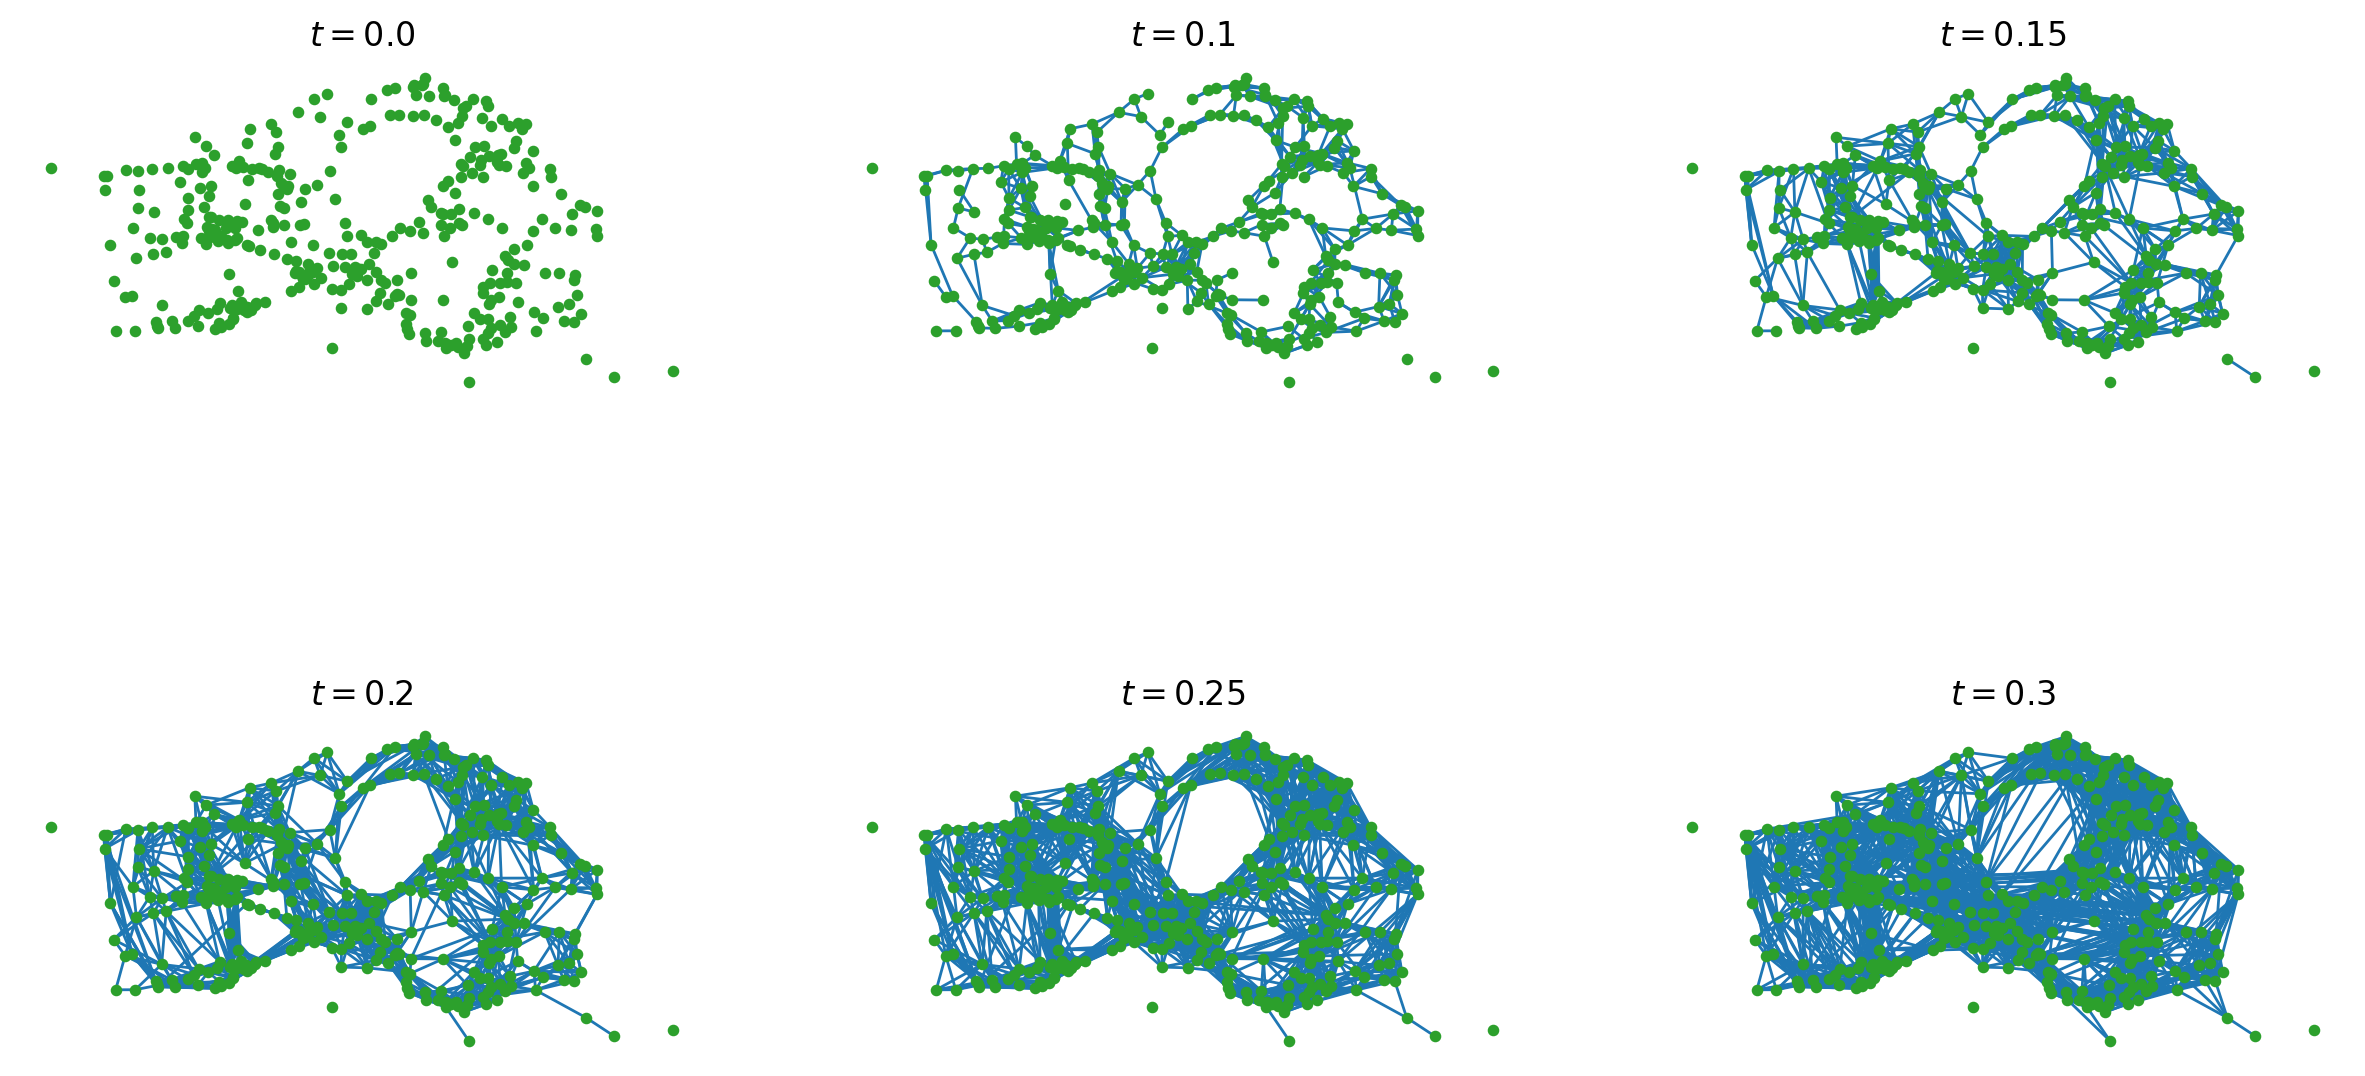

In [20]:
filtration_cycle = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3]
fig, ax = myplt.get_axes(len(filtration_cycle), max_col=3, res=200)
for i,fil in enumerate(filtration_cycle):
    filtration = mytop.get_filtration(emb_data['1omp'],VRcomplexes['1omp'],r=fil)
    mytop.plt_filtration(emb_data['1omp'], filtration, r=fil, dotsize=10, axes=ax[i])
    ax[i].set_title(r'$t='+str(fil)+'$')
    ax[i].set_aspect('equal')
if SAVE_PLOT:
    plt.savefig("filtration_1omp.svg")

### Active site visualization

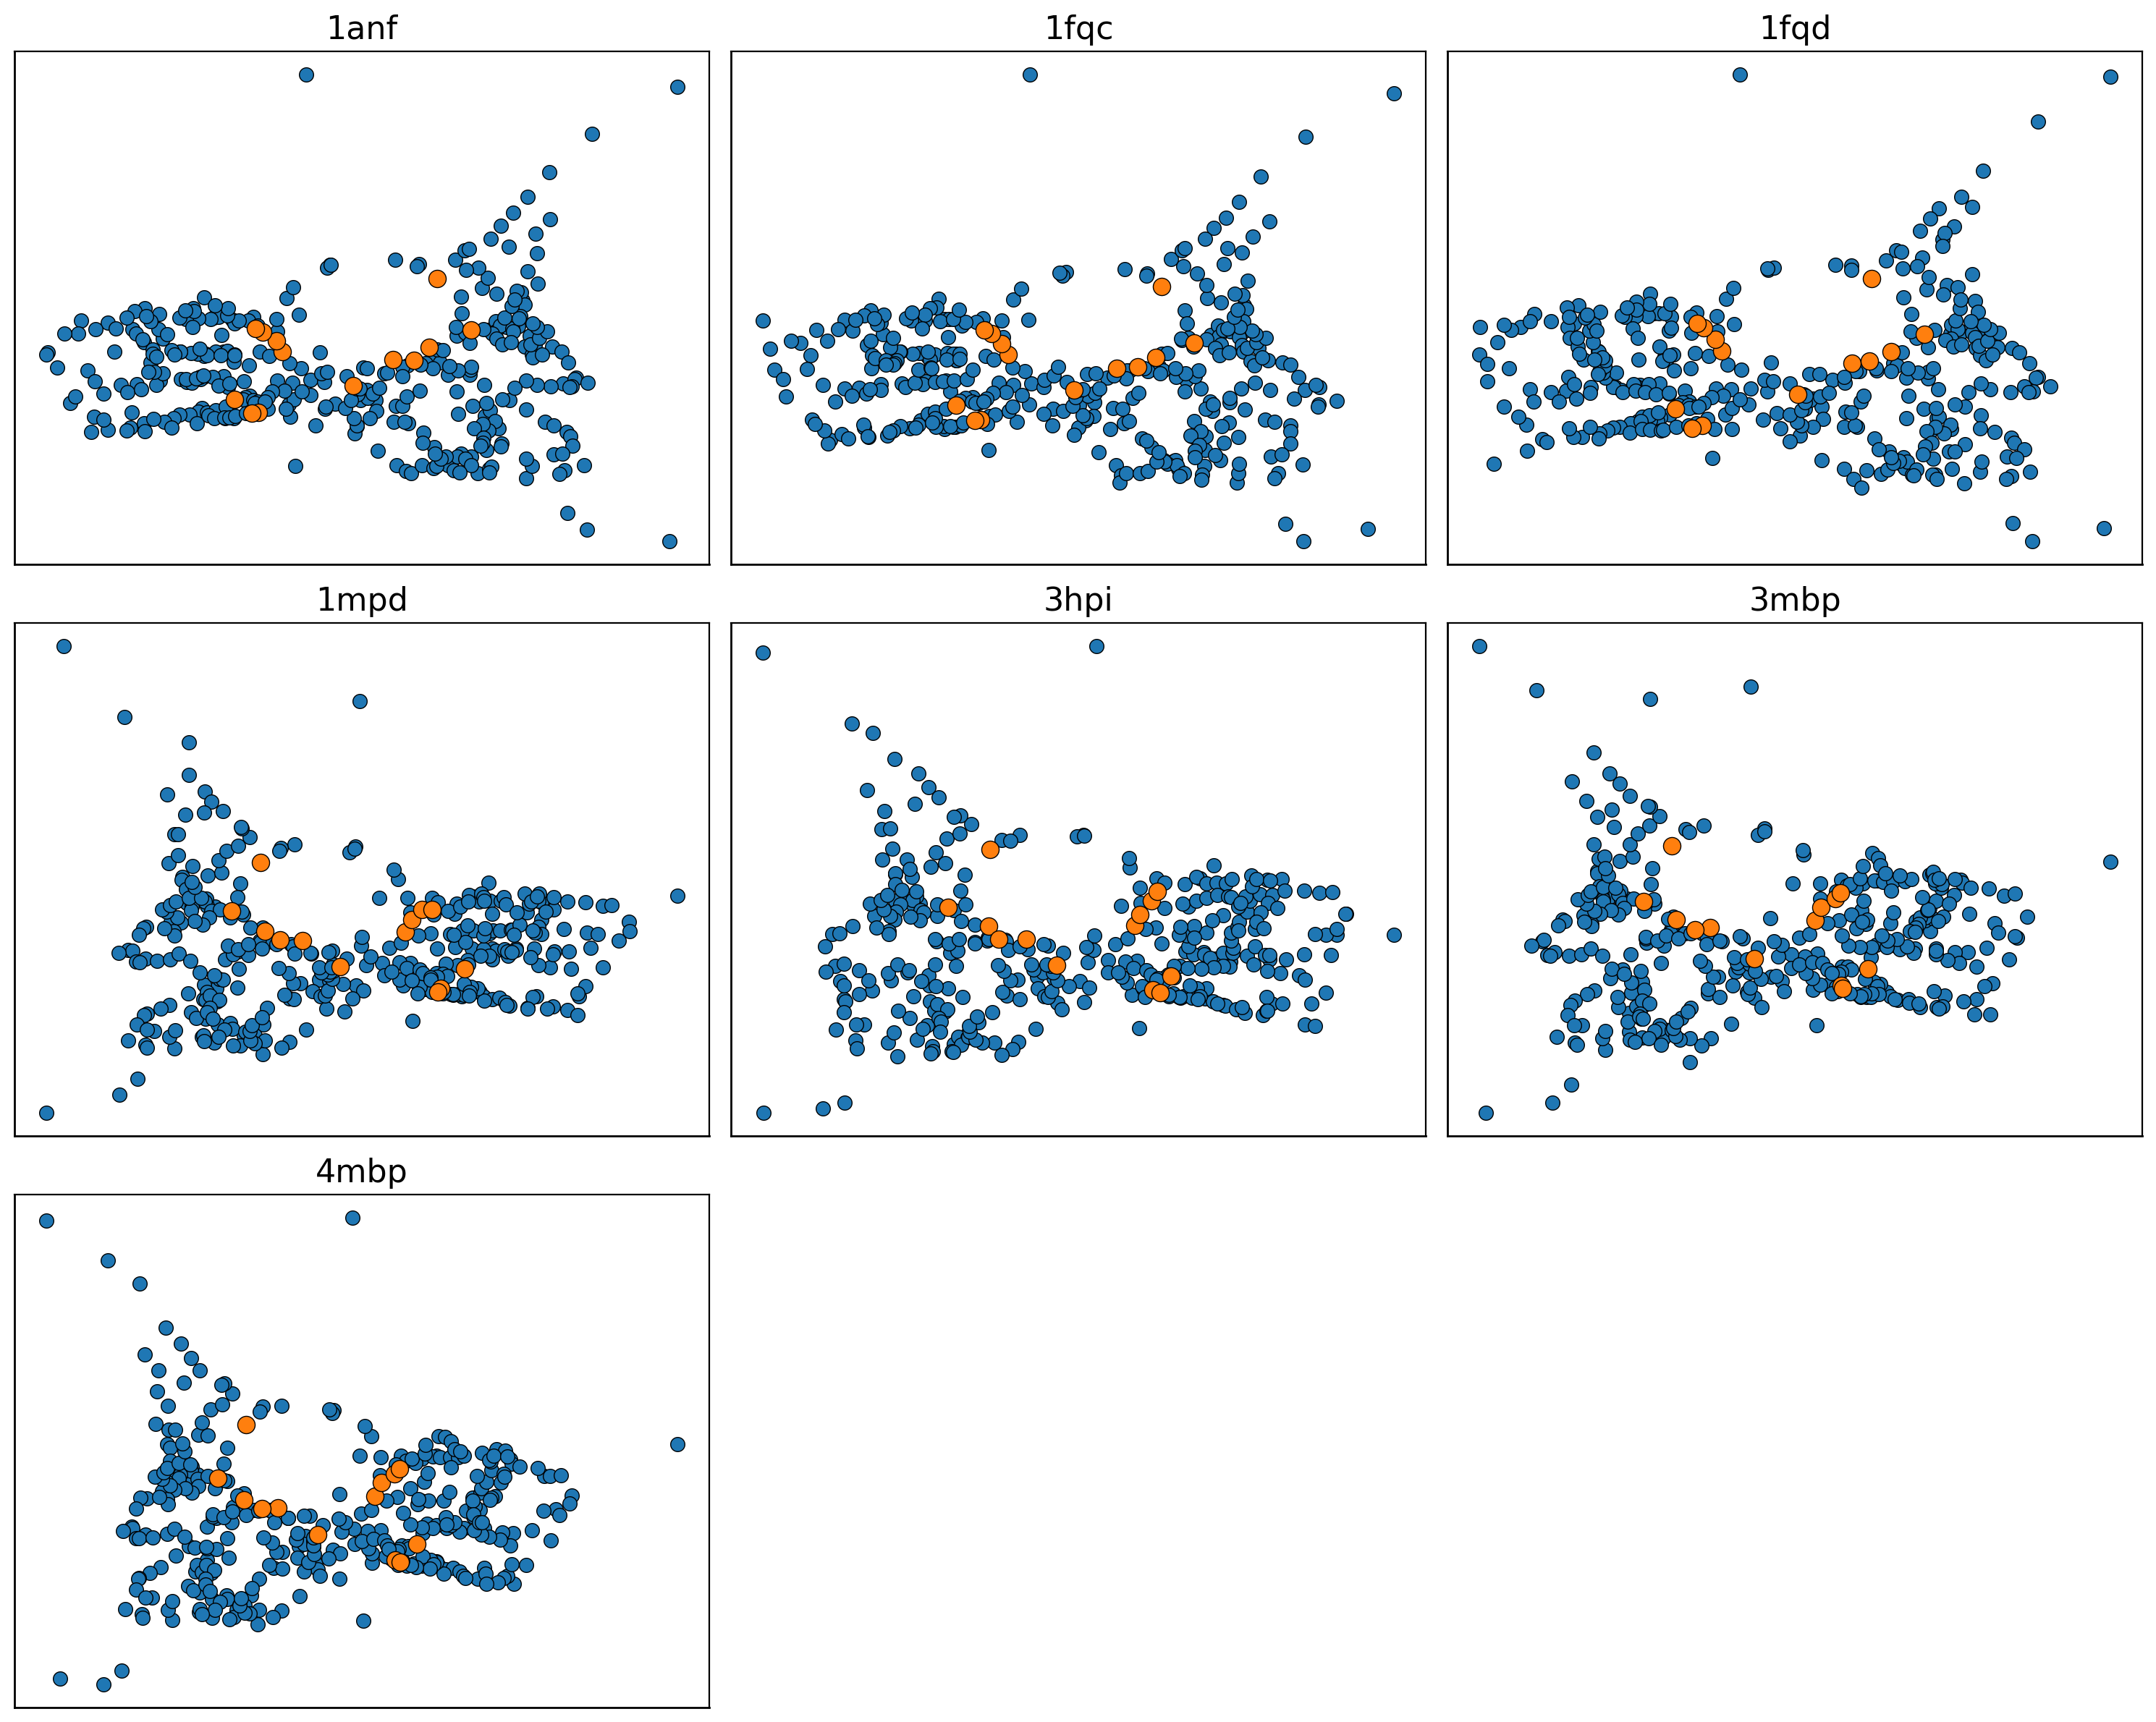

In [29]:
dummy_filtration = 0.15
count = 0
fig, ax = myplt.get_axes(len(closed_ndx), max_col=3, res=200)
for i,j in enumerate(emb_data):
    if i in closed_ndx:
        myplt.single_scatter_axe(emb_data[j], ax[count], s=50)
        myplt.single_scatter_axe(emb_data[j][active_res], ax[count], color='tab:orange', s=75)
        ax[count].set_title(j, size=16)
        
        for side in ['bottom','left']:
            ax[count].spines[side].set_linewidth(1)
        for side in ['right','top']:
            ax[count].spines[side].set_visible(True)
        ax[count].set_yticks([])
        ax[count].set_xticks([])
        ax[count].xaxis.set_ticks_position('none')
        ax[count].yaxis.set_ticks_position('none')
    
        count+=1
        
fig.tight_layout()
# if SAVE_PLOT:
plt.savefig("active_sites.svg")

In [27]:
RES = 500
silhouettes_dim0 = {
    vr: mytop.get_silhouette_new(VRcomplexes[vr], res=RES, dim=0) for vr in VISUAL
}

silhouettes_dim1 = {
    vr: mytop.get_silhouette_new(VRcomplexes[vr], res=RES) for vr in VISUAL
}

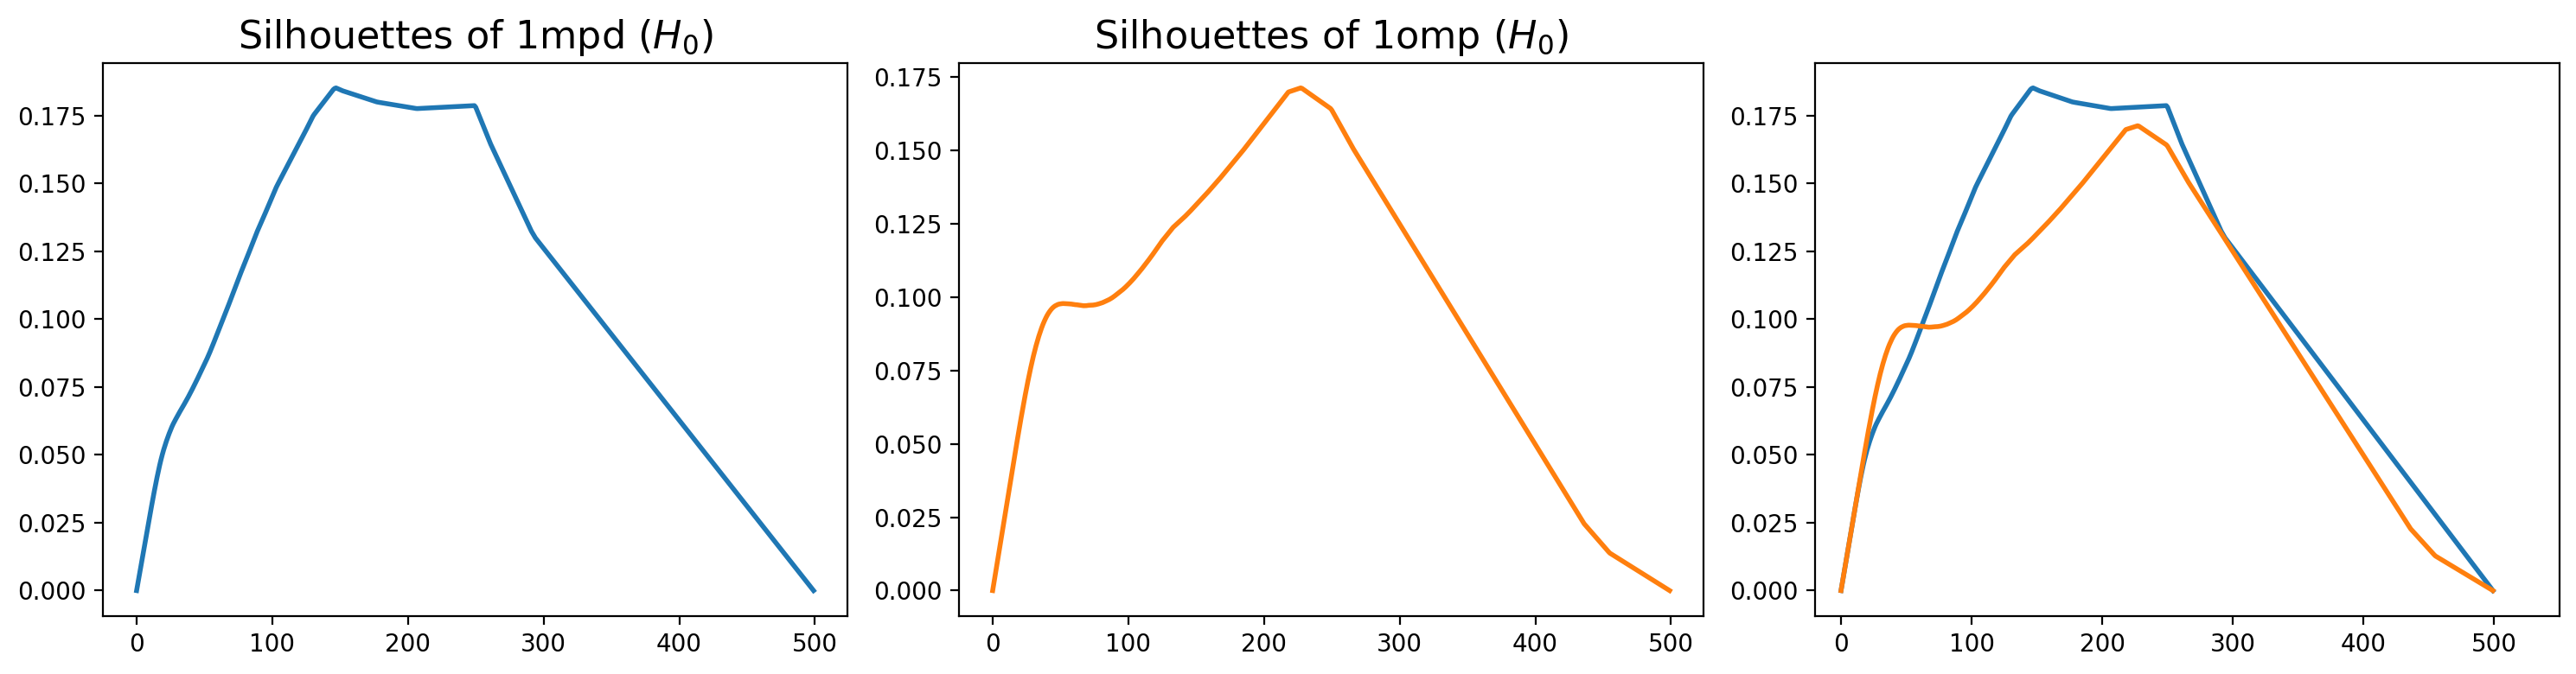

In [28]:
palette = myplt.myPalette(2, palette='tab10')
fig, ax = myplt.get_axes(len(silhouettes_dim0)+1, max_col=3, res=200)
for i,j in enumerate(silhouettes_dim0):
    ax[i].plot(silhouettes_dim0[j][0], linewidth=2, c=palette[i])
    ax[i].set_title(r'Silhouettes of '+j+' ($H_0$)', size=16)
    ax[2].plot(silhouettes_dim0[j][0], linewidth=2, c=palette[i])
ax[2].set_xlim((-20,550))
# myplt.axarrows(fig,ax[2])
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("silhouettes_h0.svg")

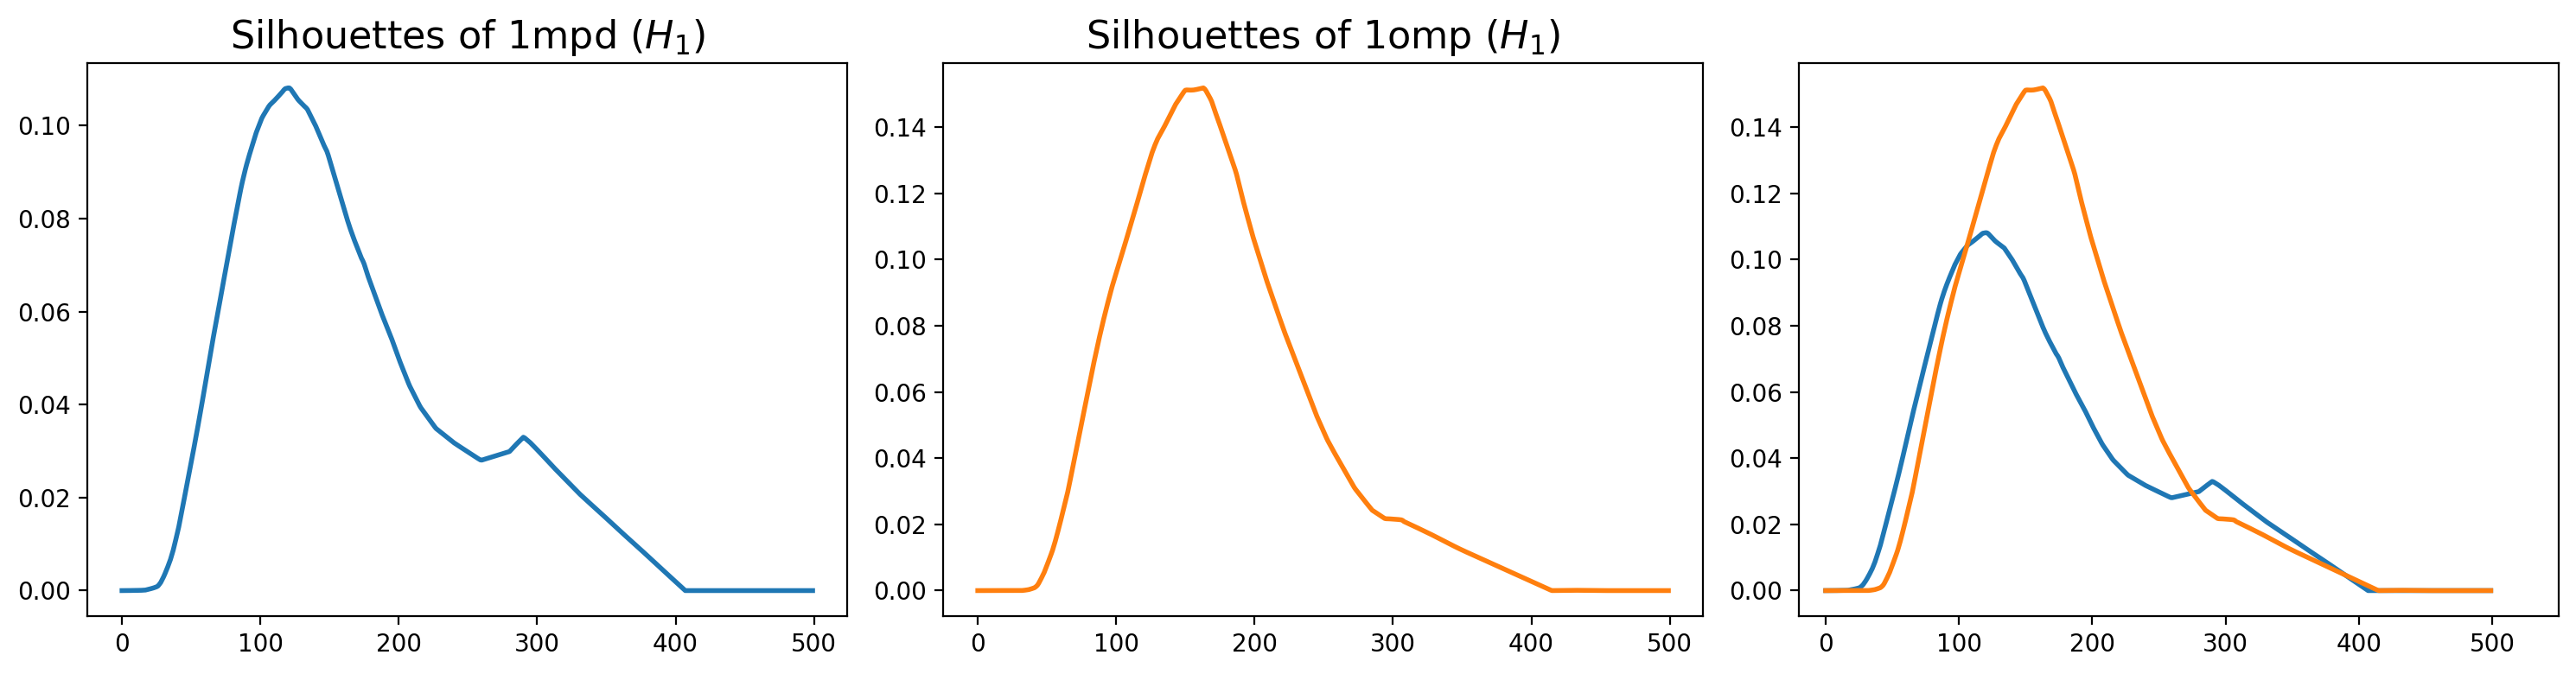

In [29]:
palette = myplt.myPalette(2, palette='tab10')
fig, ax = myplt.get_axes(len(silhouettes_dim1)+1, max_col=3, res=200)
for i,j in enumerate(silhouettes_dim1):
    ax[i].plot(silhouettes_dim1[j][0], linewidth=2, c=palette[i])
    ax[i].set_title(r'Silhouettes of '+j+' ($H_1$)', size=16)
    ax[2].plot(silhouettes_dim1[j][0], linewidth=2, c=palette[i])
ax[2].set_xlim((-20,550))
# myplt.axarrows(fig,ax[2])
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("silhouettes_h1.svg")

In [30]:
persistence_list0 = []
persistence_list1 = []

for i,vrc in enumerate(VRcomplexes):
    print(vrc)
    persistence_list0.append(VRcomplexes[vrc].persistence_intervals_in_dimension(0))
    persistence_list1.append(VRcomplexes[vrc].persistence_intervals_in_dimension(1))

1anf
1ez9
1fqa
1fqb
1fqc
1fqd
1jw4
1jw5
1lls
1mpd
1omp
3hpi
3mbp
4mbp


In [31]:
l = len(VRcomplexes)
print(f"Number of systems: {l}")
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))

Number of systems: 14


In [32]:
for i in range(l):
    for j in range(i):
        B0[i,j] = gd.bottleneck_distance(persistence_list0[i], persistence_list0[j], 0.001)
        B1[i,j] = gd.bottleneck_distance(persistence_list1[i], persistence_list1[j])
        
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()

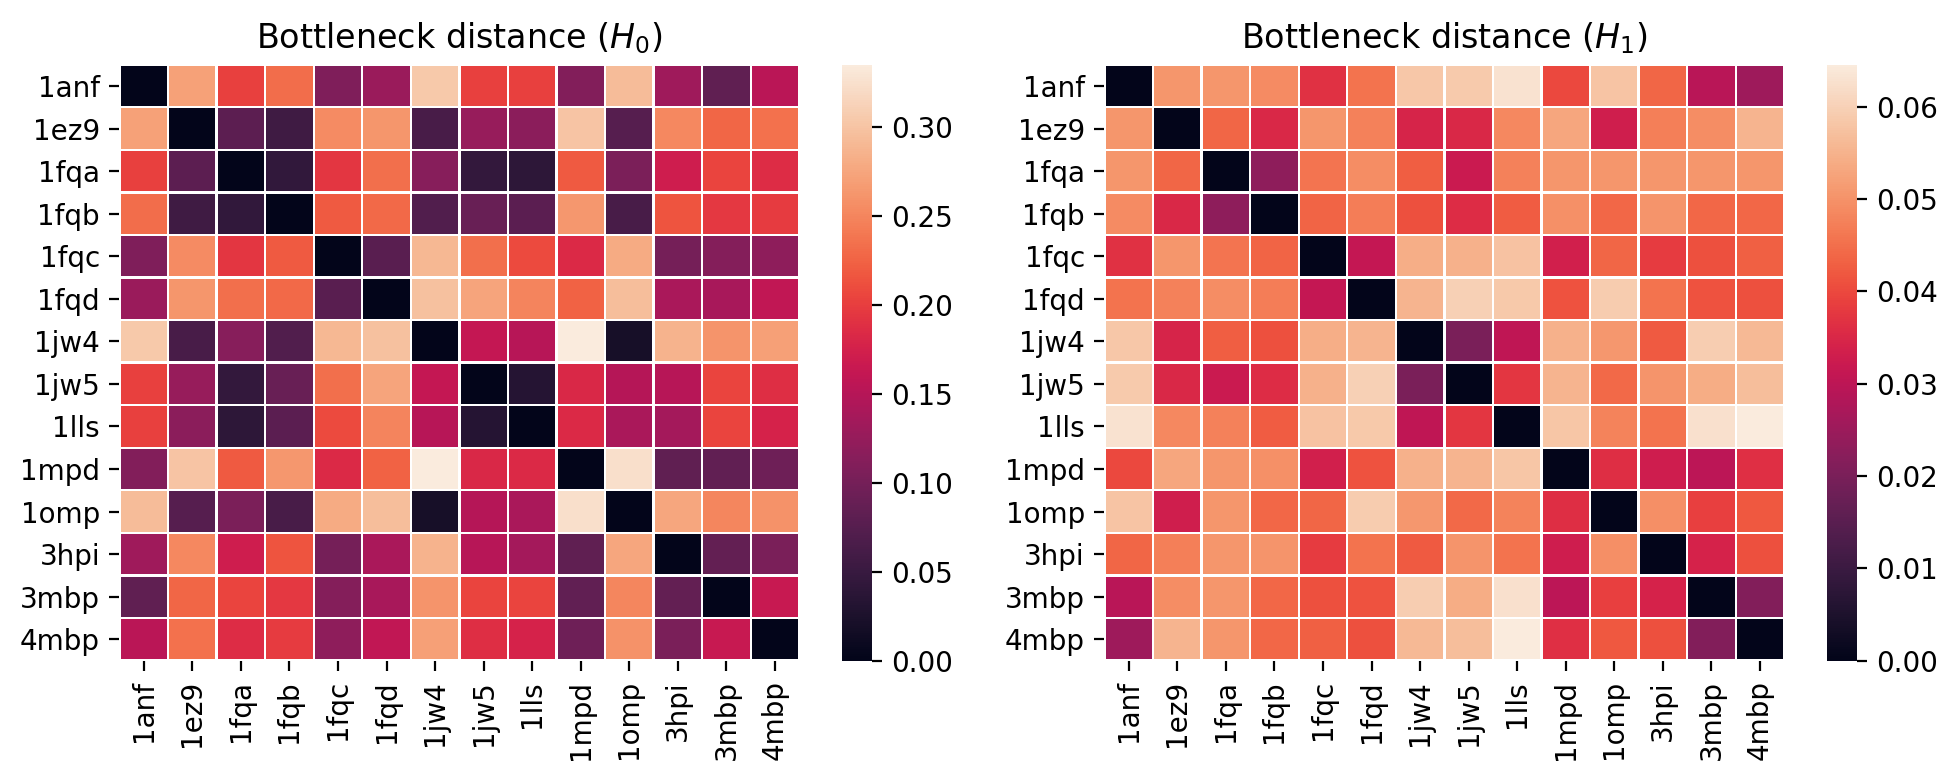

In [37]:
labels = [txt[:4] for i,txt in enumerate(file_list)]
fig, ax = myplt.get_axes(2, max_col=2, res=200)
hm1 = sns.heatmap(B0, ax=ax[0],
            xticklabels=labels, yticklabels=labels,
            linewidths=.5, linecolor='w'
                 )
hm2 = sns.heatmap(B1, ax=ax[1],
            xticklabels=labels, yticklabels=labels,
            linewidths=.5, linecolor='w'
                 )

ax[0].set_title(r"Bottleneck distance $(H_0)$")
ax[1].set_title(r"Bottleneck distance $(H_1)$")
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("bottleneck_distmatrix.svg")

In [41]:
distEmbedding = MDS(n_components=2,
                    dissimilarity='precomputed')

In [42]:
pos0 = distEmbedding.fit_transform(B0)
pos1 = distEmbedding.fit_transform(B1)

In [44]:
np.savetxt('dist_pos0.dat', pos0)
np.savetxt('dist_pos1.dat', pos1)

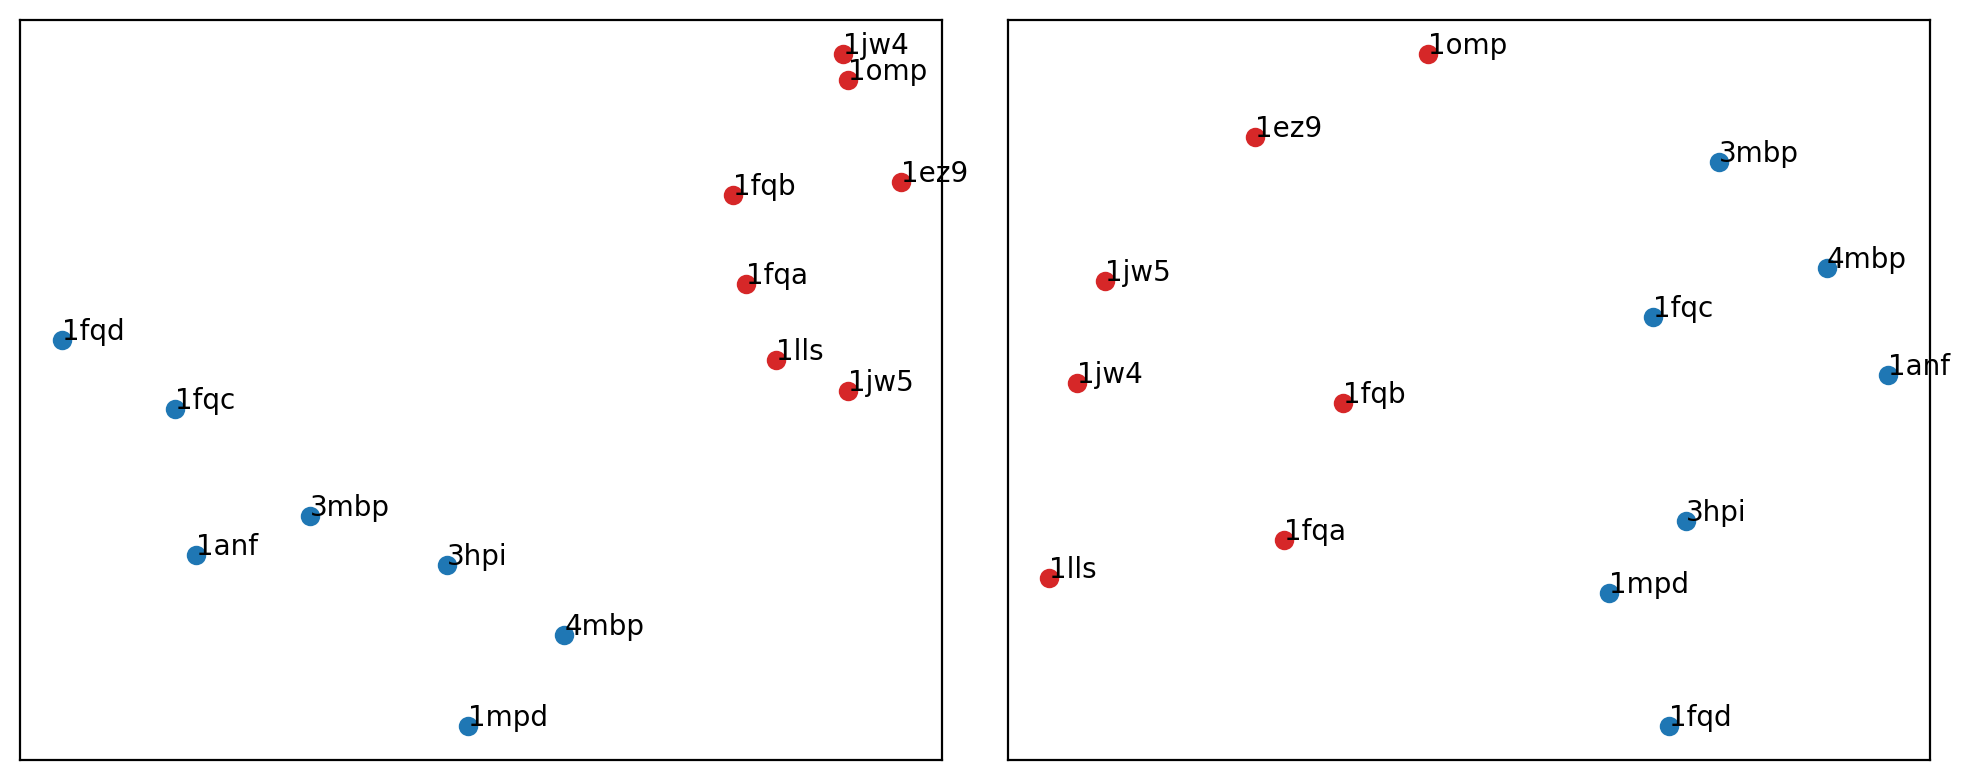

In [46]:
fig, ax = myplt.get_axes(2, max_col=2, res=200)
for conf in range(len(file_list)):
    if conf in open_ndx:
        ax[0].scatter(pos0[conf,0], pos0[conf,1], c='tab:red', label='open')
        ax[1].scatter(pos1[conf,0], pos1[conf,1], c='tab:red', label='open')
    elif conf in closed_ndx:
        ax[0].scatter(pos0[conf,0], pos0[conf,1], c='tab:blue', label='closed')
        ax[1].scatter(pos1[conf,0], pos1[conf,1], c='tab:blue', label='closed')
            
for i, txt in enumerate(file_list):
    ax[0].annotate(txt[:4], (pos0[i,0], pos0[i,1]))
    ax[1].annotate(txt[:4], (pos1[i,0], pos1[i,1]))
    
for x in range(2):
    ax[x].set_yticks([])
    ax[x].set_xticks([])
    ax[x].xaxis.set_ticks_position('none')
    ax[x].yaxis.set_ticks_position('none')
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("embedded_bottleneck_dist.svg")

## SVM visualization

In [47]:
from sklearn.svm import SVC

In [48]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=.8,
               linestyles=['--', '-', '--'])
    
    cm = plt.cm.RdBu_r
    ax.contourf(X, Y, P, cmap=cm, alpha=.8)
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');


In [49]:
ds_configurations = [pos0, pos1]
model = SVC(kernel='linear', C=1E10)

In [50]:
SVMmodels = dict()
for h,H in enumerate(ds_configurations):
    X = H
    y = list()
    for conf in range(len(file_list)):
        if conf in open_ndx:
            y.append(1)
        elif conf in closed_ndx:
            y.append(0)
    
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
  
    SVMmodels['B'+str(h)] = model

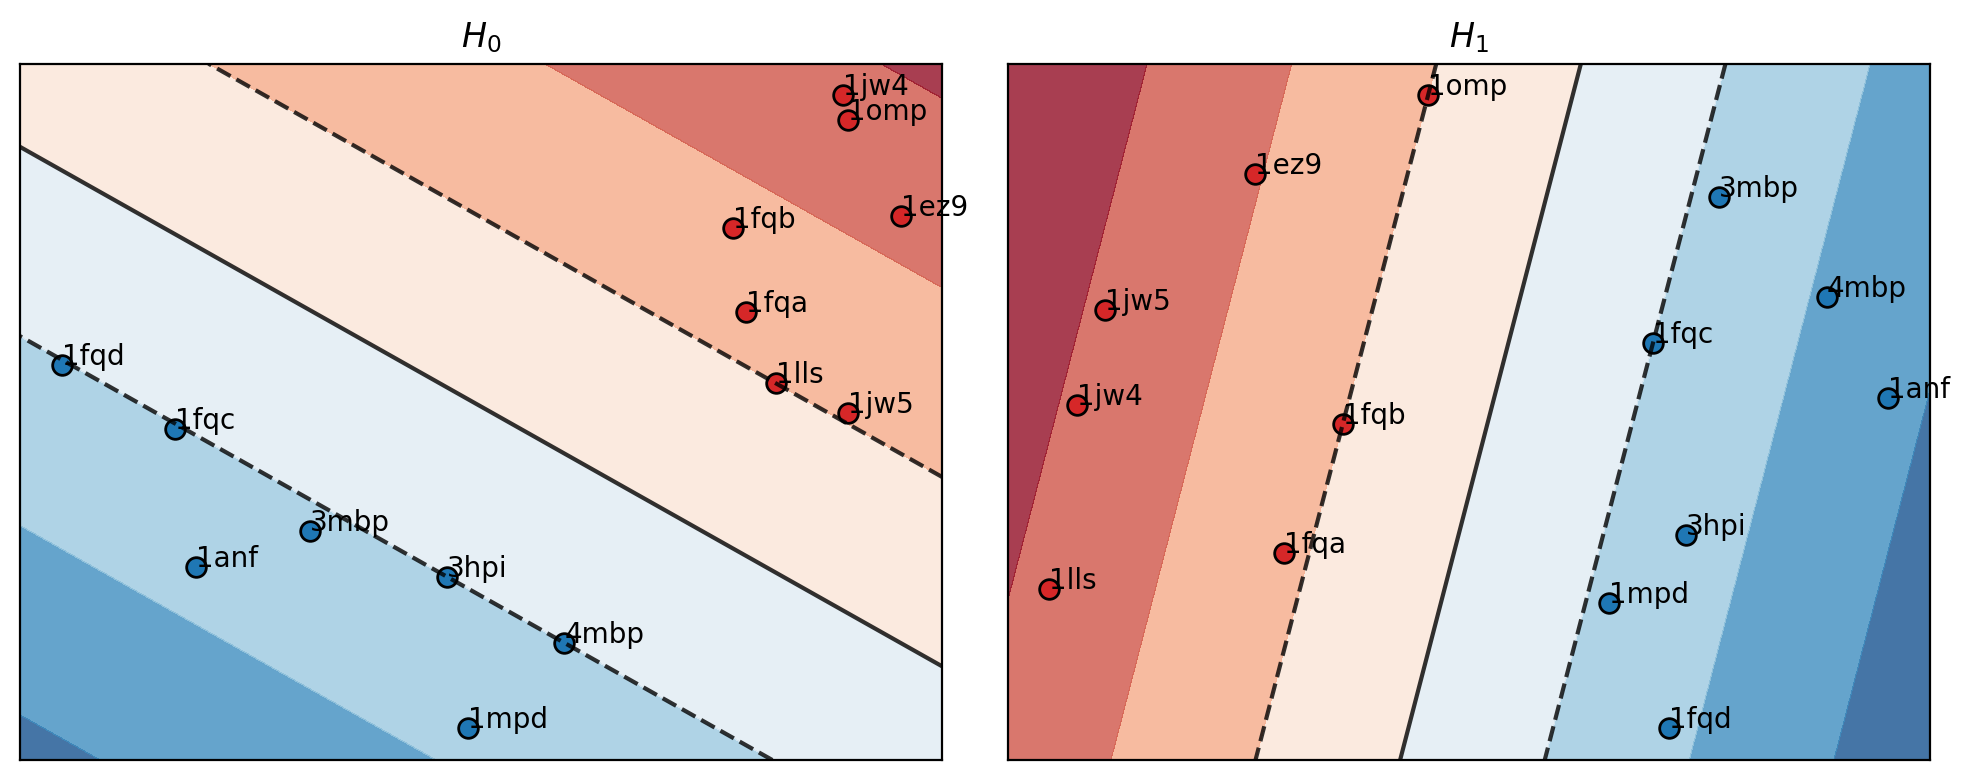

In [52]:
fig, ax = myplt.get_axes(2, max_col=2, res=200)
for i,ds in enumerate(SVMmodels):
    
    X = ds_configurations[i]
    ax[i].scatter(X[:,0], X[:,1], zorder=-1)
#     ax[i].autoscale(False)
    plot_svc_decision_function(SVMmodels[ds], ax[i]);
    
    for conf in range(len(file_list)):
        if conf in open_ndx:
            ax[i].scatter(X[conf,0], X[conf,1], c='tab:red', edgecolor='k', s=50, label='open', zorder=1)
        elif conf in closed_ndx:
            ax[i].scatter(X[conf,0], X[conf,1], c='tab:blue', edgecolor='k', s=50, label='closed', zorder=1)

    for j, txt in enumerate(file_list):
        ax[i].annotate(txt[:4], (X[j,0], X[j,1]))
    ax[i].set_title(f"$H_{i}$")
    
for x in range(2):
    ax[x].set_yticks([])
    ax[x].set_xticks([])
    ax[x].xaxis.set_ticks_position('none')
    ax[x].yaxis.set_ticks_position('none')
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("embedded_bottleneck_dist_svm.svg")